# 33150 PSET 5
# Giovanni Longo (12228450)

#### ChatGPT was used for basic function debugging and plotnine assistance.

#### Begin by importing necessary libraries and setting varibales.

In [2]:
from plotnine import aes
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import requests
import re
import sys
from tqdm import tqdm
import statsmodels.api as sm
import functools
import seaborn as sns
import patchworklib as pw
import itertools
import plotnine as p9
import datetime
import os
import hashlib
import io
from matplotlib.image import imread

quandl.ApiConfig.api_key = '1n-fMYgMqmbySCU-zs6e'
start_date = '2016-01-01' 
end_date = '2023-06-30'

<Figure size 100x100 with 0 Axes>

#### First, we define our standard function to grab data from the quandl api.

In [318]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key='1n-fMYgMqmbySCU-zs6e', **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

#### Let us download the appropriate data we will need for our strategy. The first series we want is IUDSOIA so that we can access the GBP swap rates. Next, we want to use the quandl API so that we can get all of our FX rates over the sample period. Finally, we will download our swap rate data from the InferredYieldCurves file, but we also have to keep in mind that this file only contains the spot yield curves. We will have to adjust the curves so that they are the zero curves instead, which we explain after downloading all our data.

In [319]:
url = 'https://www.bankofengland.co.uk/boeapps/database/_iadb-fromshowcolumns.asp?csv.x=yes'
params = {
    'Datefrom':'01/Jan/2012',
    'Dateto':'now',            
    'SeriesCodes':'IUDSOIA',  
    'CSVF':'TN',              
    'UsingCodes':'Y', 
    'VPD':'Y',                
    'VFD':'N'
}

# Without this argument, we get a status_code of 500 (an Internal Server Error)
headers= {
'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    GBP_rates = pd.read_csv(io.StringIO(response.text))
    GBP_rates.DATE = pd.to_datetime(GBP_rates.DATE)
    GBP_rates.set_index('DATE', inplace=True)
else:
   print("Could not retrieve data. Please try again.")
   
GBP_rates

,IUDSOIA
DATE,
2012-01-03,0.5169
2012-01-04,0.5269
2012-01-05,0.5077
2012-01-06,0.5038
2012-01-09,0.5128
...,...
2024-02-06,5.1894
2024-02-07,5.1890
2024-02-08,5.1880


In [320]:
fx_rates = fetch_quandl_table('EDI/CUR', avoid_download=True)
fx_rates

Skipping any possible download of EDI/CUR


,code,date,rate
0,AED,2023-07-20,3.672900
1,AFN,2023-07-20,85.664367
2,ALL,2023-07-20,90.165179
3,AMD,2023-07-20,389.973810
4,ANG,2023-07-20,1.801893
...,...,...,...
1349556,ZWL,2023-07-14,322.000000
1349557,ZWL,2023-07-15,322.000000
1349558,ZWL,2023-07-16,322.000000
1349559,ZWL,2023-07-17,322.000000


In [624]:
inferred_yield_curves = pd.read_csv('InferredYieldCurves_2024.tab', delimiter='\t') 
inferred_yield_curves

,Unnamed: 0,shortname,tenor,date,yield
0,3401,Arab Rep Egypt,10Y,2010-01-04,0.075885
1,3402,Arab Rep Egypt,10Y,2010-01-05,0.074642
2,3403,Arab Rep Egypt,10Y,2010-01-06,0.074318
3,3404,Arab Rep Egypt,10Y,2010-01-07,0.073642
4,3405,Arab Rep Egypt,10Y,2010-01-08,0.073024
...,...,...,...,...,...
324689,323564,Utd Mexican Sts,6M,2024-01-29,0.053356
324690,323565,Utd Mexican Sts,6M,2024-01-30,0.053339
324691,323566,Utd Mexican Sts,6M,2024-01-31,0.053286
324692,323567,Utd Mexican Sts,6M,2024-02-01,0.052837


#### Now that we have the raw data loaded, we need to find the correct subset of the data frame that corresponds to our analysis. We are asked to find the spot FX rates for the USD vs. GBP, Egyptian Pound (EGP), Hungarian Forint (HUF), Costa Rican Colon (CRC), and Romanian Leu (RON). Additionally, for the last four currencies, we are also required to find the swap yield curves. However, remember that our data was given to us as spot yield curves, and we want zero curves. Therefore, we will have to find the yield curve data for EGP, HUF, CRC, and RON and convert it to zero curve data.

In [322]:
def get_currency_data(data, curr_code, code_column='code'):
    '''
    Takes in a data frame and returns the appropriate currency data based on 
    the given currency code (and code column). 
    '''
    rates = data[data[code_column] == curr_code].copy()
    rates.sort_values(by='date', inplace=True)
    rates.set_index('date', inplace=True)
    
    return rates

In [323]:
GBP_fx_rates = get_currency_data(fx_rates, 'GBP')
GBP_fx_rates.index = pd.to_datetime(GBP_fx_rates.index)
EGP_fx_rates = get_currency_data(fx_rates, 'EGP')
HUF_fx_rates = get_currency_data(fx_rates, 'HUF')
CRC_fx_rates = get_currency_data(fx_rates, 'CRC')
RON_fx_rates = get_currency_data(fx_rates, 'RON')

In [324]:
# We need to find what the names are to the corresponding currencies. We see here that
# we need Arab Rep Egypt, Hungary, Rep Costa Rica, and Romania
inferred_yield_curves.shortname.unique()

array(['Arab Rep Egypt', 'Federative Rep Brazil', 'Hungary',
       'Islamic Rep Pakistan', 'Kdom Thailand', 'Rep Colombia',
       'Rep Costa Rica', 'Rep El Salvador', 'Rep Guatemala',
       'Rep Kazakhstan', 'Rep Panama', 'Rep Peru', 'Rep Poland',
       'Rep South Africa', 'Rep Trinidad & Tobago', 'Rep Turkey',
       'Rep of Angola', 'Rep of Ghana', 'Rep of Iraq', 'Rep of Serbia',
       'Romania', 'Socialist Rep Vietnam', 'Utd Mexican Sts'],
      dtype=object)

In [325]:
EGP_yield_curves = get_currency_data(
    inferred_yield_curves, 
    curr_code='Arab Rep Egypt', 
    code_column='shortname'
).drop(columns=['Unnamed: 0'])

HUF_yield_curves = get_currency_data(
    inferred_yield_curves, 
    curr_code='Hungary', 
    code_column='shortname'
).drop(columns=['Unnamed: 0'])

CRC_yield_curves = get_currency_data(
    inferred_yield_curves, 
    curr_code='Rep Costa Rica', 
    code_column='shortname'
).drop(columns=['Unnamed: 0'])

RON_yield_curves = get_currency_data(
    inferred_yield_curves, 
    curr_code='Romania', 
    code_column='shortname'
).drop(columns=['Unnamed: 0'])

#### Now that we have the specific currencies that we are interested in, we will create a combined data frame that contains all the relevant information for a singular currency. So, our first step to achieve this combined df is to separate the yield curves by their tenor and find the zero curves for each specific date.

In [326]:
EGP_yield_curves

,shortname,tenor,yield
date,,,
2010-01-04,Arab Rep Egypt,10Y,0.075885
2010-01-04,Arab Rep Egypt,6M,0.023642
2010-01-04,Arab Rep Egypt,5Y,0.061109
2010-01-04,Arab Rep Egypt,1Y,0.028901
2010-01-05,Arab Rep Egypt,6M,0.023556
...,...,...,...
2024-02-01,Arab Rep Egypt,6M,0.113028
2024-02-02,Arab Rep Egypt,1Y,0.152971
2024-02-02,Arab Rep Egypt,5Y,0.192975


In [327]:
def reshape_yield_data(df):
    '''
    Reshape the data frame to have separate columns for each tenor's yield, indexed by date.
    '''
    df['tenor'] = df['tenor'].replace({'6M':'0.5Y'})
    
    pivot_df = df.pivot( columns='tenor', values='yield')
    
    pivot_df.columns = [f'{col}' for col in pivot_df.columns]
    
    pivot_df.rename(columns={'0.5Y':'0.5', '1Y':'1.0', '5Y':'5.0', '10Y':'10.0'}, inplace=True)
    
    move_columns = ['0.5', '1.0', '5.0', '10.0']
    
    return pivot_df[move_columns]

In [328]:
EGP_yields_by_tenor = reshape_yield_data(EGP_yield_curves)
HUF_yields_by_tenor = reshape_yield_data(HUF_yield_curves)
CRC_yields_by_tenor = reshape_yield_data(CRC_yield_curves)
RON_yields_by_tenor = reshape_yield_data(RON_yield_curves)

In [329]:
EGP_yields_by_tenor

,0.5,1.0,5.0,10.0
date,,,,
2010-01-04,0.023642,0.028901,0.061109,0.075885
2010-01-05,0.023556,0.027466,0.059096,0.074642
2010-01-06,0.024841,0.027161,0.058905,0.074318
2010-01-07,0.025263,0.026656,0.058715,0.073642
2010-01-08,0.024984,0.026583,0.057959,0.073024
...,...,...,...,...
2024-01-29,0.137792,0.174729,0.215379,0.192608
2024-01-30,0.138899,0.167042,0.206339,0.184911
2024-01-31,0.117218,0.156395,0.196064,0.177383


In [331]:
def compute_zcb_curve(df, curr_name):
    zcb_rates = df.copy()

    for tenor in df.columns:
        tenor_value = float(tenor)
        tenor_values = df.columns.astype(float) 
        for index, row in df.iterrows(): 
            times = np.arange(tenor_value - 0.5, 0, step=-0.5)[::-1]
            coupon_half_yr = 0.5 * row[tenor]  
            z = np.interp(times, tenor_values, row.values.astype(float))
            preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
            log_argument = (1 - preceding_coupons_val) / (1 + coupon_half_yr)
            zcb_rate = -np.log(log_argument) / tenor_value
            zcb_rates.at[index, tenor] = zcb_rate

    zcb_rates.rename(columns={'0.5':f'{curr_name}_0.5Y', 
                             '1.0':f'{curr_name}_1Y', 
                              '5.0':f'{curr_name}_5Y', 
                              '10.0':f'{curr_name}_10Y'}, inplace=True)
    
    return zcb_rates

In [332]:
EGP_zero_curves = compute_zcb_curve(EGP_yields_by_tenor, 'EGP')
HUF_zero_curves = compute_zcb_curve(HUF_yields_by_tenor, 'HUF')
CRC_zero_curves = compute_zcb_curve(CRC_yields_by_tenor, 'CRC')
RON_zero_curves = compute_zcb_curve(RON_yields_by_tenor, 'RON')

In [333]:
EGP_zero_curves

,EGP_0.5Y,EGP_1Y,EGP_5Y,EGP_10Y
date,,,,
2010-01-04,0.023503,0.028730,0.062411,0.080887
2010-01-05,0.023418,0.027305,0.060337,0.079774
2010-01-06,0.024688,0.026993,0.060147,0.079384
2010-01-07,0.025105,0.026488,0.059974,0.078518
2010-01-08,0.024829,0.026417,0.059166,0.077855
...,...,...,...,...
2024-01-29,0.133252,0.168822,0.212492,0.159910
2024-01-30,0.134288,0.161336,0.203674,0.155651
2024-01-31,0.113911,0.151897,0.194717,0.153292


In [334]:
EGP_combined = (pd.merge(EGP_zero_curves, EGP_fx_rates, left_index=True, right_index=True, how='inner')
                .drop(columns=['code']).rename(columns={'rate':'EGP_rate'}))
HUF_combined = (pd.merge(HUF_zero_curves, HUF_fx_rates, left_index=True, right_index=True, how='inner')
                .drop(columns=['code']).rename(columns={'rate':'HUF_rate'}))
CRC_combined = (pd.merge(CRC_zero_curves, CRC_fx_rates, left_index=True, right_index=True, how='inner')
                .drop(columns=['code']).rename(columns={'rate':'CRC_rate'}))
RON_combined = (pd.merge(RON_zero_curves, RON_fx_rates, left_index=True, right_index=True, how='inner')
                .drop(columns=['code']).rename(columns={'rate':'RON_rate'}))

In [343]:
EGP_combined

,EGP_0.5Y,EGP_1Y,EGP_5Y,EGP_10Y,EGP_rate
date,,,,,
2010-01-04,0.023503,0.028730,0.062411,0.080887,5.486981
2010-01-05,0.023418,0.027305,0.060337,0.079774,5.465845
2010-01-06,0.024688,0.026993,0.060147,0.079384,5.454573
2010-01-07,0.025105,0.026488,0.059974,0.078518,5.451902
2010-01-08,0.024829,0.026417,0.059166,0.077855,5.449738
...,...,...,...,...,...
2024-01-29,0.133252,0.168822,0.212492,0.159910,30.999770
2024-01-30,0.134288,0.161336,0.203674,0.155651,30.899300
2024-01-31,0.113911,0.151897,0.194717,0.153292,30.900600


In [344]:
HUF_combined

,HUF_0.5Y,HUF_1Y,HUF_5Y,HUF_10Y,HUF_rate
date,,,,,
2012-01-02,NaN,NaN,NaN,NaN,243.036998
2012-01-03,0.062827,0.072210,0.094572,0.108541,242.379737
2012-01-04,0.076733,0.085214,0.103132,0.115783,247.300105
2012-01-05,0.079081,0.086943,0.106017,0.118772,249.820811
2012-01-06,0.075820,0.083024,0.099785,0.110703,248.797313
...,...,...,...,...,...
2024-01-29,0.055611,0.053355,0.057017,0.063393,358.072000
2024-01-30,0.055601,0.053734,0.057271,0.062806,359.781466
2024-01-31,0.055508,0.053051,0.056383,0.062047,357.290322


In [345]:
CRC_combined

,CRC_0.5Y,CRC_1Y,CRC_5Y,CRC_10Y,CRC_rate
date,,,,,
2010-01-04,0.011452,0.012717,0.046608,0.064307,559.290882
2010-01-05,0.007142,0.012130,0.045761,0.065353,559.418301
2010-01-06,0.006748,0.011949,0.045991,0.063533,560.918803
2010-01-07,0.006848,0.011779,0.045372,0.062810,558.428865
2010-01-08,0.006554,0.015337,0.044564,0.062496,558.084731
...,...,...,...,...,...
2024-01-29,0.105161,0.100973,0.092990,0.094503,512.448895
2024-01-30,0.105146,0.101347,0.093234,0.094136,510.472754
2024-01-31,0.105044,0.100663,0.092384,0.093595,513.329162


In [346]:
RON_combined

,RON_0.5Y,RON_1Y,RON_5Y,RON_10Y,RON_rate
date,,,,,
2010-01-04,0.032889,0.037277,0.065696,0.081065,2.933135
2010-01-05,0.029107,0.032621,0.060020,0.075470,2.903328
2010-01-06,0.023525,0.029204,0.060614,0.076710,2.895457
2010-01-07,0.022125,0.026379,0.059713,0.075485,2.915677
2010-01-08,0.021895,0.026246,0.058464,0.074606,2.914286
...,...,...,...,...,...
2024-01-29,0.058073,0.053766,0.059673,0.069438,4.592100
2024-01-30,0.058155,0.054238,0.059943,0.069092,4.598700
2024-01-31,0.058130,0.053618,0.059023,0.068428,4.599000


#### With our newly combined dataframes, we can begin implementing our carry strategy, which entails borrowing from the cheap interest rate (GBP) and loaning to the risky interest rate (EGP, etc.) at a 4:1 leverage. We are going to borrow 8 million from the GBP and loan 10 million total to the risky currency, where the additional 2 million is from our own capital. Note then that when we calculate our interest payment for the loan we take out, we are only calculating interest on the 8 million that we have borrowed from the British pound, but we are seeing overall profits from the FX rate changes on our investment and the changes in bond price. To begin, we are going to look at the Egyptian pound first. Note that we will only need data once a week, so we are going to adhere to the industry standard and take the Wednesday of every week over our sample period. Also, we will observe the 5-year tenor as instructed.

In [527]:
def create_strategy_dataframe(curr_df, curr_name, spot_df):
    '''
    Takes in the combined currency dataframe and returns a dataframe that is ready
    to create the columns necessary to calculate our PnL for the carry trades.
    '''
    df = curr_df.copy()
    
    df.index = pd.to_datetime(df.index)
    
    columns_to_fill = [f'{curr_name}_0.5Y', f'{curr_name}_1Y', f'{curr_name}_5Y', f'{curr_name}_10Y']
    for column in columns_to_fill:
        df[column].fillna(method='ffill', inplace=True)
    
    spot_df.index = pd.to_datetime(spot_df.index)
    spot_df['5.0'].fillna(method='ffill', inplace=True)
    
    strat_df = pd.merge(df, spot_df['5.0'], left_index=True, right_index=True, how='inner')
    
    GBP_rates.index = pd.to_datetime(GBP_rates.index)
    
    strat_df = pd.merge(strat_df, GBP_rates['IUDSOIA']/100, left_index=True, right_index=True, how='inner')
    
    strat_df = (pd.merge(strat_df, GBP_fx_rates['rate'], left_index=True, right_index=True, how='inner')
                      .rename(columns={'rate':'GBP_rate', '5.0':f'{curr_name}_5Y_spot'}))

    strat_df = strat_df[strat_df.index.dayofweek == 2]

    return strat_df

In [528]:
EGP_strategy_data = create_strategy_dataframe(EGP_combined, 'EGP', EGP_yields_by_tenor)
HUF_strategy_data = create_strategy_dataframe(HUF_combined, 'HUF', HUF_yields_by_tenor)
CRC_strategy_data = create_strategy_dataframe(CRC_combined, 'CRC', CRC_yields_by_tenor)
RON_strategy_data = create_strategy_dataframe(RON_combined, 'RON', RON_yields_by_tenor)

In [529]:
EGP_strategy_data

,EGP_0.5Y,EGP_1Y,EGP_5Y,EGP_10Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate
2012-01-04,0.057239,0.068058,0.093155,0.109770,6.032009,0.092895,0.005269,0.640657
2012-01-11,0.055070,0.067569,0.093516,0.109996,6.037501,0.093155,0.005156,0.651322
2012-01-18,0.053903,0.060472,0.086318,0.101796,6.043214,0.085851,0.005220,0.648996
2012-01-25,0.039251,0.052187,0.084263,0.102780,6.041476,0.083095,0.005171,0.641089
2012-02-01,0.041037,0.051301,0.081968,0.100064,6.030446,0.080931,0.005010,0.631153
...,...,...,...,...,...,...,...,...
2024-01-03,0.153050,0.169424,0.197486,0.148987,30.898900,0.204007,0.051863,0.791621
2024-01-10,0.159687,0.170578,0.202035,0.149596,30.905900,0.208308,0.051872,0.787423
2024-01-17,0.164533,0.181130,0.208911,0.152079,30.904000,0.217051,0.051880,0.793105
2024-01-24,0.132212,0.161317,0.200456,0.155456,30.898700,0.203664,0.051875,0.787268


In [530]:
HUF_strategy_data

,HUF_0.5Y,HUF_1Y,HUF_5Y,HUF_10Y,HUF_rate,HUF_5Y_spot,IUDSOIA,GBP_rate
2012-01-04,0.076733,0.085214,0.103132,0.115783,247.300105,0.104110,0.005269,0.640657
2012-01-11,0.074240,0.081759,0.097146,0.107271,245.109913,0.098181,0.005156,0.651322
2012-01-18,0.075864,0.082934,0.095217,0.104738,238.253870,0.096538,0.005220,0.648996
2012-01-25,0.061702,0.070653,0.085800,0.100245,229.481270,0.086404,0.005171,0.641089
2012-02-01,0.060414,0.068510,0.082542,0.095679,221.691598,0.083153,0.005010,0.631153
...,...,...,...,...,...,...,...,...
2024-01-03,0.057293,0.054891,0.056817,0.062004,348.500500,0.057626,0.051863,0.791621
2024-01-10,0.056494,0.054331,0.057638,0.063338,346.922527,0.058381,0.051872,0.787423
2024-01-17,0.056457,0.054388,0.058354,0.064601,349.583847,0.059075,0.051880,0.793105
2024-01-24,0.055855,0.054091,0.057867,0.064970,355.492175,0.058584,0.051875,0.787268


In [531]:
CRC_strategy_data

,CRC_0.5Y,CRC_1Y,CRC_5Y,CRC_10Y,CRC_rate,CRC_5Y_spot,IUDSOIA,GBP_rate
2012-01-04,0.016888,0.021435,0.044507,0.063413,508.673245,0.043903,0.005269,0.640657
2012-01-11,0.016789,0.021336,0.044093,0.063229,508.708656,0.033469,0.005156,0.651322
2012-01-18,0.016165,0.020988,0.040923,0.057882,504.743661,0.040471,0.005220,0.648996
2012-01-25,0.014805,0.018340,0.037152,0.054711,512.635372,0.032350,0.005171,0.641089
2012-02-01,0.015777,0.020062,0.037590,0.055086,508.553900,0.037242,0.005010,0.631153
...,...,...,...,...,...,...,...,...
2024-01-03,0.105699,0.101420,0.092202,0.092505,520.476696,0.095978,0.051863,0.791621
2024-01-10,0.105508,0.101521,0.093114,0.093886,519.568310,0.096862,0.051872,0.787423
2024-01-17,0.105227,0.101333,0.093466,0.094610,520.446178,0.097176,0.051880,0.793105
2024-01-24,0.105419,0.101622,0.093838,0.095518,514.178907,0.097566,0.051875,0.787268


In [532]:
RON_strategy_data

,RON_0.5Y,RON_1Y,RON_5Y,RON_10Y,RON_rate,RON_5Y_spot,IUDSOIA,GBP_rate
2012-01-04,0.041958,0.048738,0.070779,0.088693,3.339661,0.070389,0.005269,0.640657
2012-01-11,0.040175,0.046686,0.068465,0.086385,3.432937,0.068064,0.005156,0.651322
2012-01-18,0.040102,0.045001,0.066991,0.084630,3.389524,0.066563,0.005220,0.648996
2012-01-25,0.035315,0.041463,0.063148,0.081810,3.349474,0.062692,0.005171,0.641089
2012-02-01,0.030791,0.037359,0.058655,0.076607,3.299478,0.058184,0.005010,0.631153
...,...,...,...,...,...,...,...,...
2024-01-03,0.056590,0.052330,0.059048,0.067134,4.538100,0.059612,0.051863,0.791621
2024-01-10,0.056442,0.052491,0.060019,0.068721,4.548500,0.060552,0.051872,0.787423
2024-01-17,0.055952,0.052043,0.060224,0.069261,4.580900,0.060717,0.051880,0.793105
2024-01-24,0.058218,0.054324,0.060628,0.070337,4.582200,0.061264,0.051875,0.787268


#### Now that we have the British interest rate, zero curve for EGP, and the conversion rates between USD/GBP and USD/EGP, we are going to make a few other columns to help us vectorize the PnL. We know that our PnL can be expressed as (new_bond_value - old_bond_value) - (new_loan_value - old_loan_value) - interest_paid. Therefore, we are going to need to calculate all of these columns within our strategy data frame. In order to calculate the new and old bond value, we will create a helper function to help us price the bonds based on the zero curve values.

In [533]:
def pricing_bonds(row, tenor, curr_name):
    coupon_rate = row[f'{curr_name}_5Y_spot']
    zcb = row[f'{curr_name}_5Y']
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    coupon_payment = coupon_rate * 50
    
    present_value_coupons = np.sum(coupon_payment * np.exp(-zcb * times))
    bond_price = 100 * np.exp(-zcb * tenor) + present_value_coupons
    
    return bond_price


def calc_bond_prices(strat_df, curr_name):
    strat_df['old_bond_price'] = strat_df.apply(pricing_bonds, args=(5.0, curr_name), axis=1)
    strat_df['new_bond_price'] = strat_df.apply(pricing_bonds, args=(259/52, curr_name), axis=1)
    
    strat_df.drop([f'{curr_name}_0.5Y', f'{curr_name}_1Y', f'{curr_name}_10Y'], inplace=True, axis=1)
    
    return strat_df

In [534]:
EGP_strat_with_bond = calc_bond_prices(EGP_strategy_data, 'EGP')
HUF_strat_with_bond = calc_bond_prices(HUF_strategy_data, 'HUF')
CRC_strat_with_bond = calc_bond_prices(CRC_strategy_data, 'CRC')
RON_strat_with_bond = calc_bond_prices(RON_strategy_data, 'RON')

In [535]:
EGP_strat_with_bond

,EGP_5Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate,old_bond_price,new_bond_price
2012-01-04,0.093155,6.032009,0.092895,0.005269,0.640657,99.037751,99.215330
2012-01-11,0.093516,6.037501,0.093155,0.005156,0.651322,98.992819,99.171006
2012-01-18,0.086318,6.043214,0.085851,0.005220,0.648996,99.063642,99.228221
2012-01-25,0.084263,6.041476,0.083095,0.005171,0.641089,98.814176,98.974429
2012-02-01,0.081968,6.030446,0.080931,0.005010,0.631153,98.899268,99.055286
...,...,...,...,...,...,...,...
2024-01-03,0.197486,30.898900,0.204007,0.051863,0.791621,98.924522,99.300931
2024-01-10,0.202035,30.905900,0.208308,0.051872,0.787423,98.718823,99.103119
2024-01-17,0.208911,30.904000,0.217051,0.051880,0.793105,99.069441,99.468256
2024-01-24,0.200456,30.898700,0.203664,0.051875,0.787268,97.843971,98.221880


#### Now that we have our bond prices, we will calculate the bond value and loan values for our strategy. From there, we will get an overall PnL for the strategy based on the carry trade performance.

In [627]:
def calc_pnl(strat_df, curr_name, drop=True, amount=10_000_000):
    '''
    Adds the current and past week bond prices to the currency stratefy df. 
    '''
    df = strat_df.copy()
    
    df['commit_to_trade'] = np.where(df['IUDSOIA'] + 0.005 > df[f'{curr_name}_5Y_spot'], 0, 1)
    
    df['new_bond_quant'] = (amount*df[f'{curr_name}_rate']) / df['old_bond_price'] * df['commit_to_trade']
    df['new_bond_value_USD'] = (df['new_bond_price'] * df['new_bond_quant'].shift(1)) / df[f'{curr_name}_rate'] * df['commit_to_trade']
    
    df['old_loan_value_GBP'] = df['GBP_rate'] * 8_000_000 * df['commit_to_trade']
    df['new_loan_value_USD'] = df['old_loan_value_GBP'].shift(1) / df['GBP_rate'] * df['commit_to_trade']
    
    df['interest_paid_USD'] = df['new_loan_value_USD'] * (df['IUDSOIA'].shift(1) + 0.005) * df['commit_to_trade'] / 52
    
    df['weekly_pnl'] = (
            (df['new_bond_value_USD'] - amount) -
            (df['new_loan_value_USD'] - 8_000_000) - 
            df['interest_paid_USD']
    ) * df['commit_to_trade']
    
    df['cumulative_pnl'] = df['weekly_pnl'].cumsum() * df['commit_to_trade']
    
    if drop:
        df.drop(columns=['new_bond_quant', 'new_bond_value_USD', 'old_loan_value_GBP', 
                    'new_loan_value_USD', 'interest_paid_USD', 'commit_to_trade', 
                     'old_bond_price', 'new_bond_price'], inplace=True, axis=1)
    
    return df

In [631]:
EGP_strat_with_pnl = calc_pnl(EGP_strategy_data, 'EGP', False)
HUF_strat_with_pnl = calc_pnl(HUF_strategy_data, 'HUF')
CRC_strat_with_pnl = calc_pnl(CRC_strategy_data, 'CRC')
RON_strat_with_pnl = calc_pnl(RON_strategy_data, 'RON')

In [632]:
EGP_strat_with_pnl

,EGP_5Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate,old_bond_price,new_bond_price,commit_to_trade,new_bond_quant,new_bond_value_USD,old_loan_value_GBP,new_loan_value_USD,interest_paid_USD,weekly_pnl,cumulative_pnl
2012-01-04,0.093155,6.032009,0.092895,0.005269,0.640657,99.037751,99.215330,1,6.090616e+05,NaN,5125256.0,NaN,NaN,NaN,NaN
2012-01-11,0.093516,6.037501,0.093155,0.005156,0.651322,98.992819,99.171006,1,6.098928e+05,1.000435e+07,5210576.0,7.869005e+06,1553.977138,133787.415870,1.337874e+05
2012-01-18,0.086318,6.043214,0.085851,0.005220,0.648996,99.063642,99.228221,1,6.100335e+05,1.001430e+07,5191968.0,8.028672e+06,1568.061397,-15936.439100,1.178510e+05
2012-01-25,0.084263,6.041476,0.083095,0.005171,0.641089,98.814176,98.974429,1,6.113977e+05,9.993869e+06,5128712.0,8.098670e+06,1591.700065,-106392.756019,1.145822e+04
2012-02-01,0.081968,6.030446,0.080931,0.005010,0.631153,98.899268,99.055286,1,6.097564e+05,1.004274e+07,5049224.0,8.125941e+06,1589.402794,-84794.879151,-7.333666e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,0.197486,30.898900,0.204007,0.051863,0.791621,98.924522,99.300931,1,3.123482e+06,1.006087e+07,6332968.0,7.937718e+06,8680.046921,114473.515685,-2.955071e+06
2024-01-10,0.202035,30.905900,0.208308,0.051872,0.787423,98.718823,99.103119,1,3.130700e+06,1.001578e+07,6299384.0,8.042651e+06,8794.793009,-35660.388698,-2.990731e+06
2024-01-17,0.208911,30.904000,0.217051,0.051880,0.793105,99.069441,99.468256,1,3.119428e+06,1.007654e+07,6344840.0,7.942686e+06,8686.854608,125162.487564,-2.865569e+06
2024-01-24,0.200456,30.898700,0.203664,0.051875,0.787268,97.843971,98.221880,1,3.157956e+06,9.916148e+06,6298144.0,8.059314e+06,8815.649602,-151981.230936,-3.017550e+06


#### Now that we have created our strategy and calculated the PnL from our carry trades, we will plot the results and test the correlations in PnL between the different risky currencies. What we are looking for specifically is a diversification opportunity between the risky currencies to lessen our exposure to the risk of holding onto a risky foreign bond. Additionally, plotting the different carry trade PnLs will allow us to examine the efficacy of these trades and to explore potential shortcomings of the strategy.

In [612]:
def plot_carry_trade_pnl(pnl_df, currency_name):
    """
    Plots the cumulative PnL for a specified currency carry strategy.
    """
    plot_df = pnl_df.copy()
    plot_df['date'] = plot_df.index
    
    carry_trade_pnl_plot = (p9.ggplot(plot_df, p9.aes(x='date', y='cumulative_pnl'))
                            + p9.geom_line(color='orange')
                            + p9.labs(title=f'Total PnL for {currency_name} Carry Strategy',
                                      x='Date',
                                      y='Total PnL')
                            + p9.theme(figure_size=(12, 8), 
                                       plot_title=p9.element_text(hjust=0.5),
                                       axis_text_x=p9.element_text(angle=45, hjust=1))
                           )
    
    return carry_trade_pnl_plot

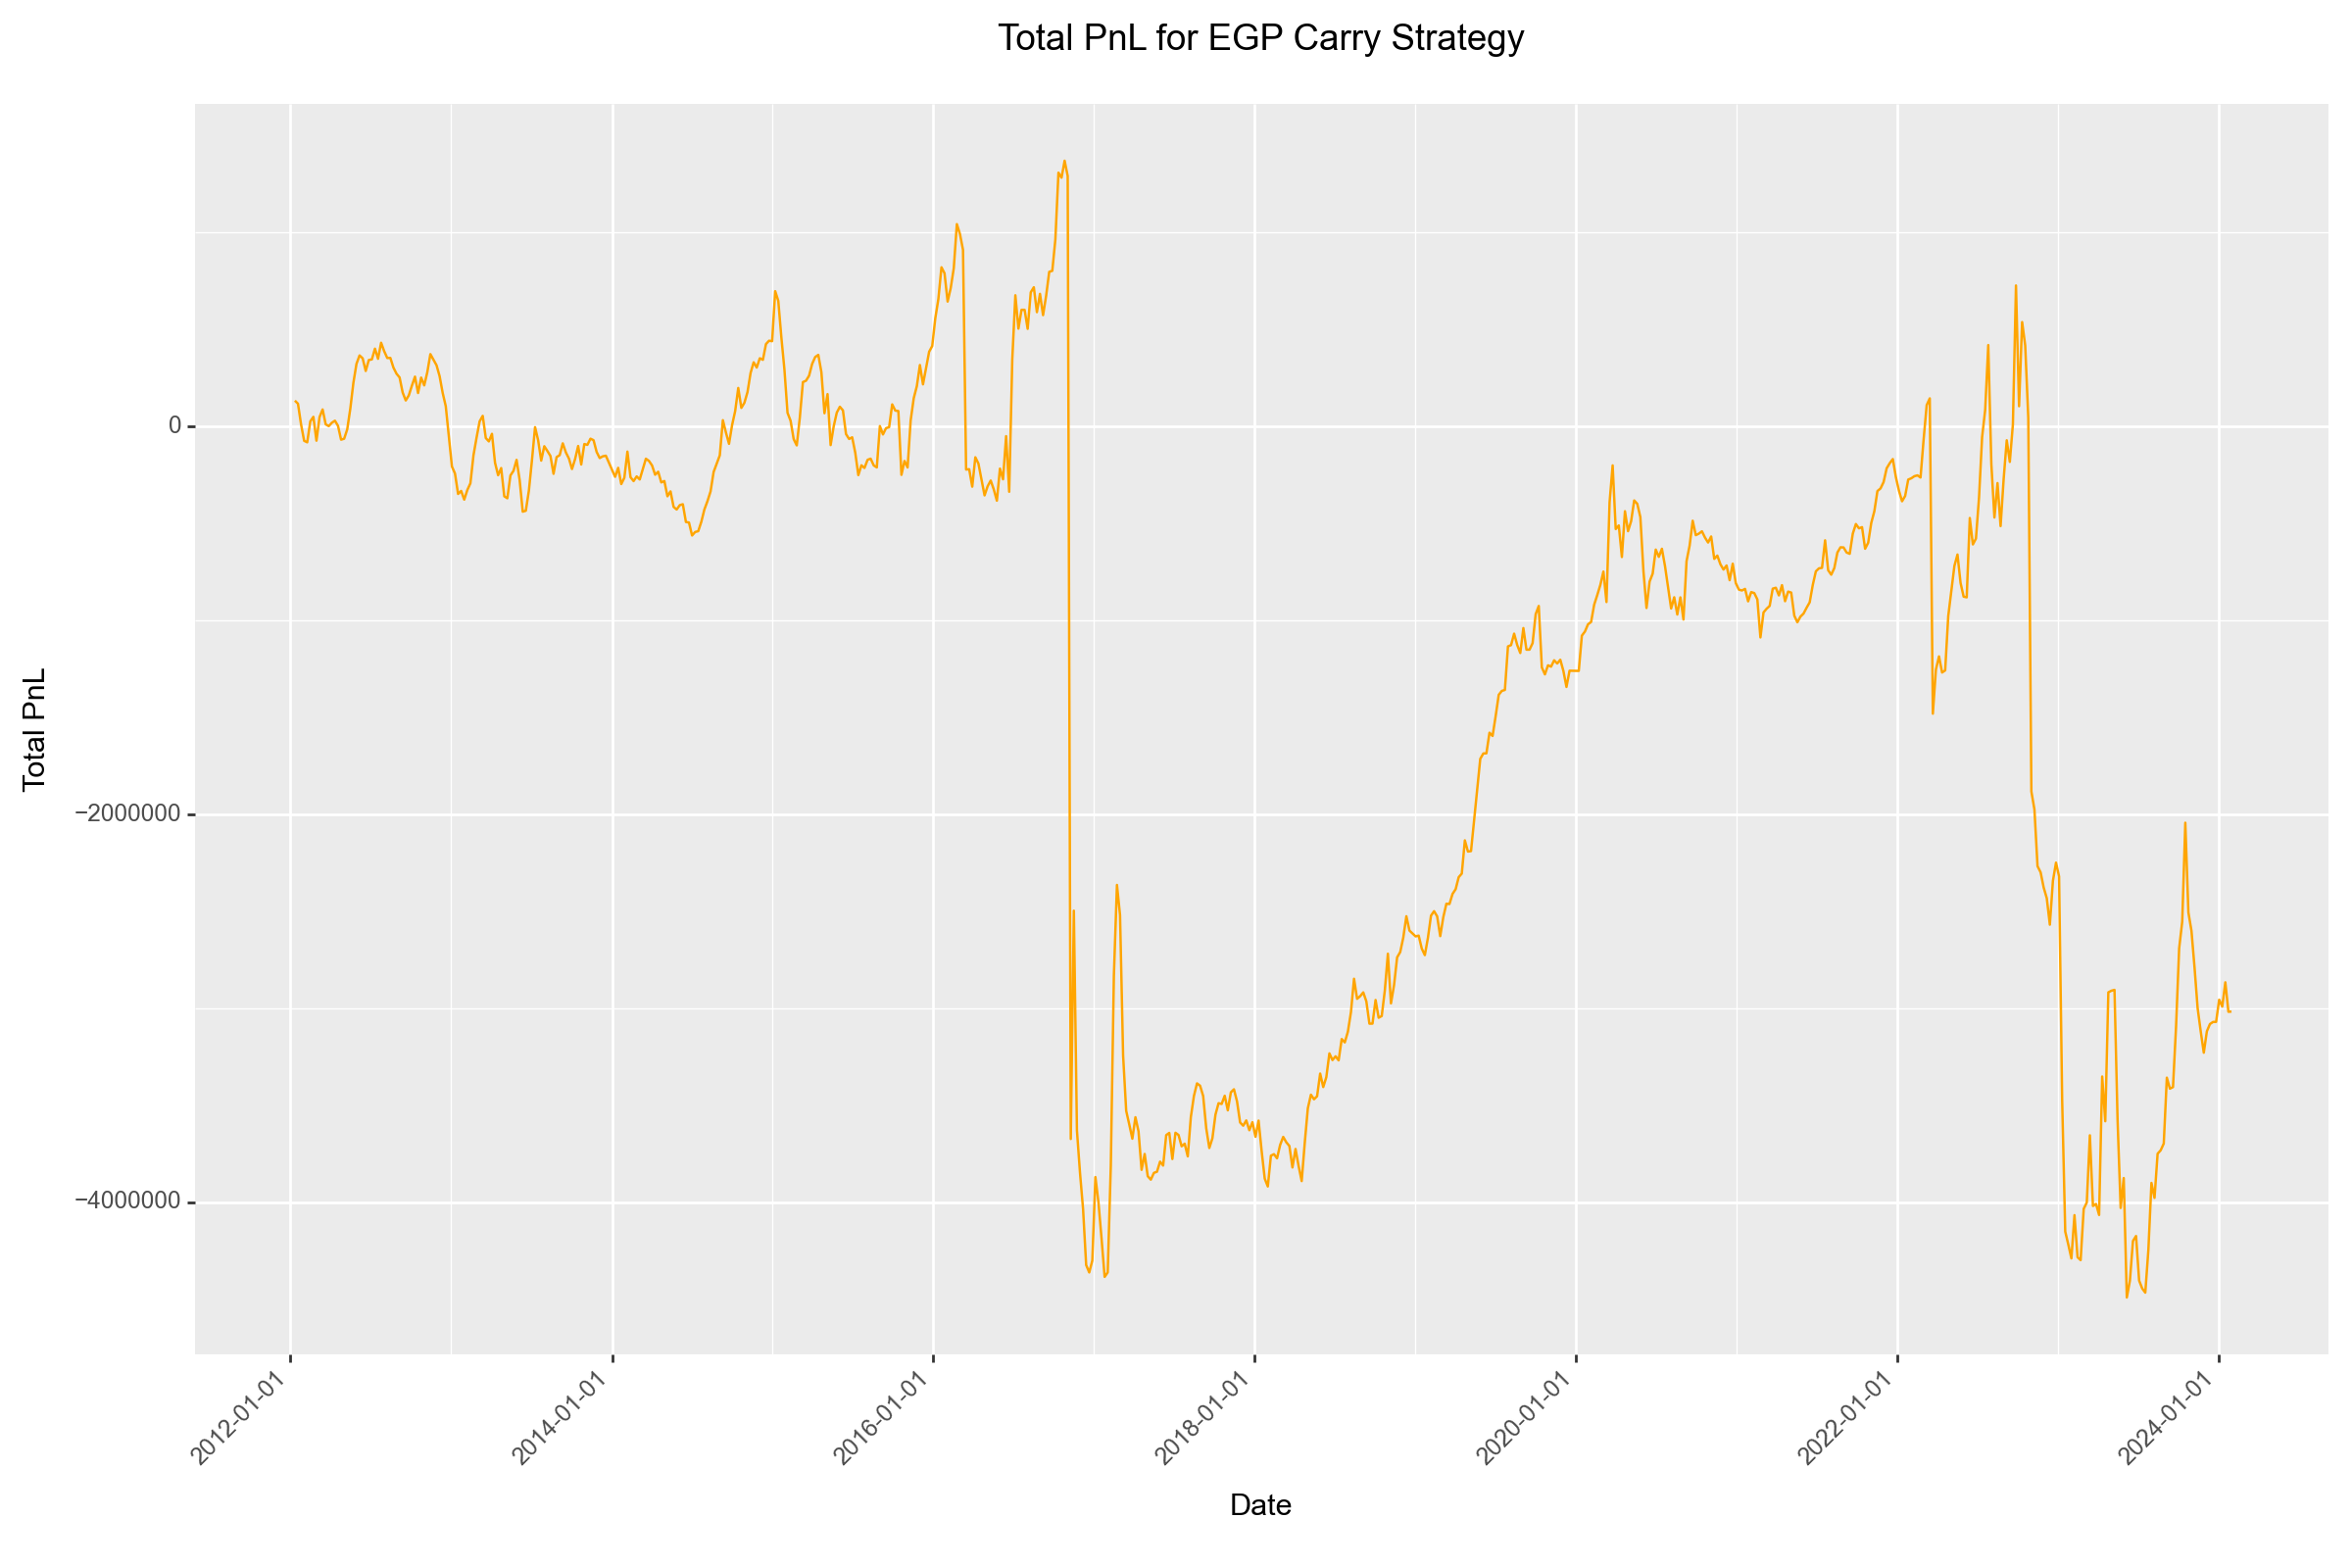

In [613]:
EGP_pnl_plot = plot_carry_trade_pnl(EGP_strat_with_pnl, 'EGP')
EGP_pnl_plot.draw()

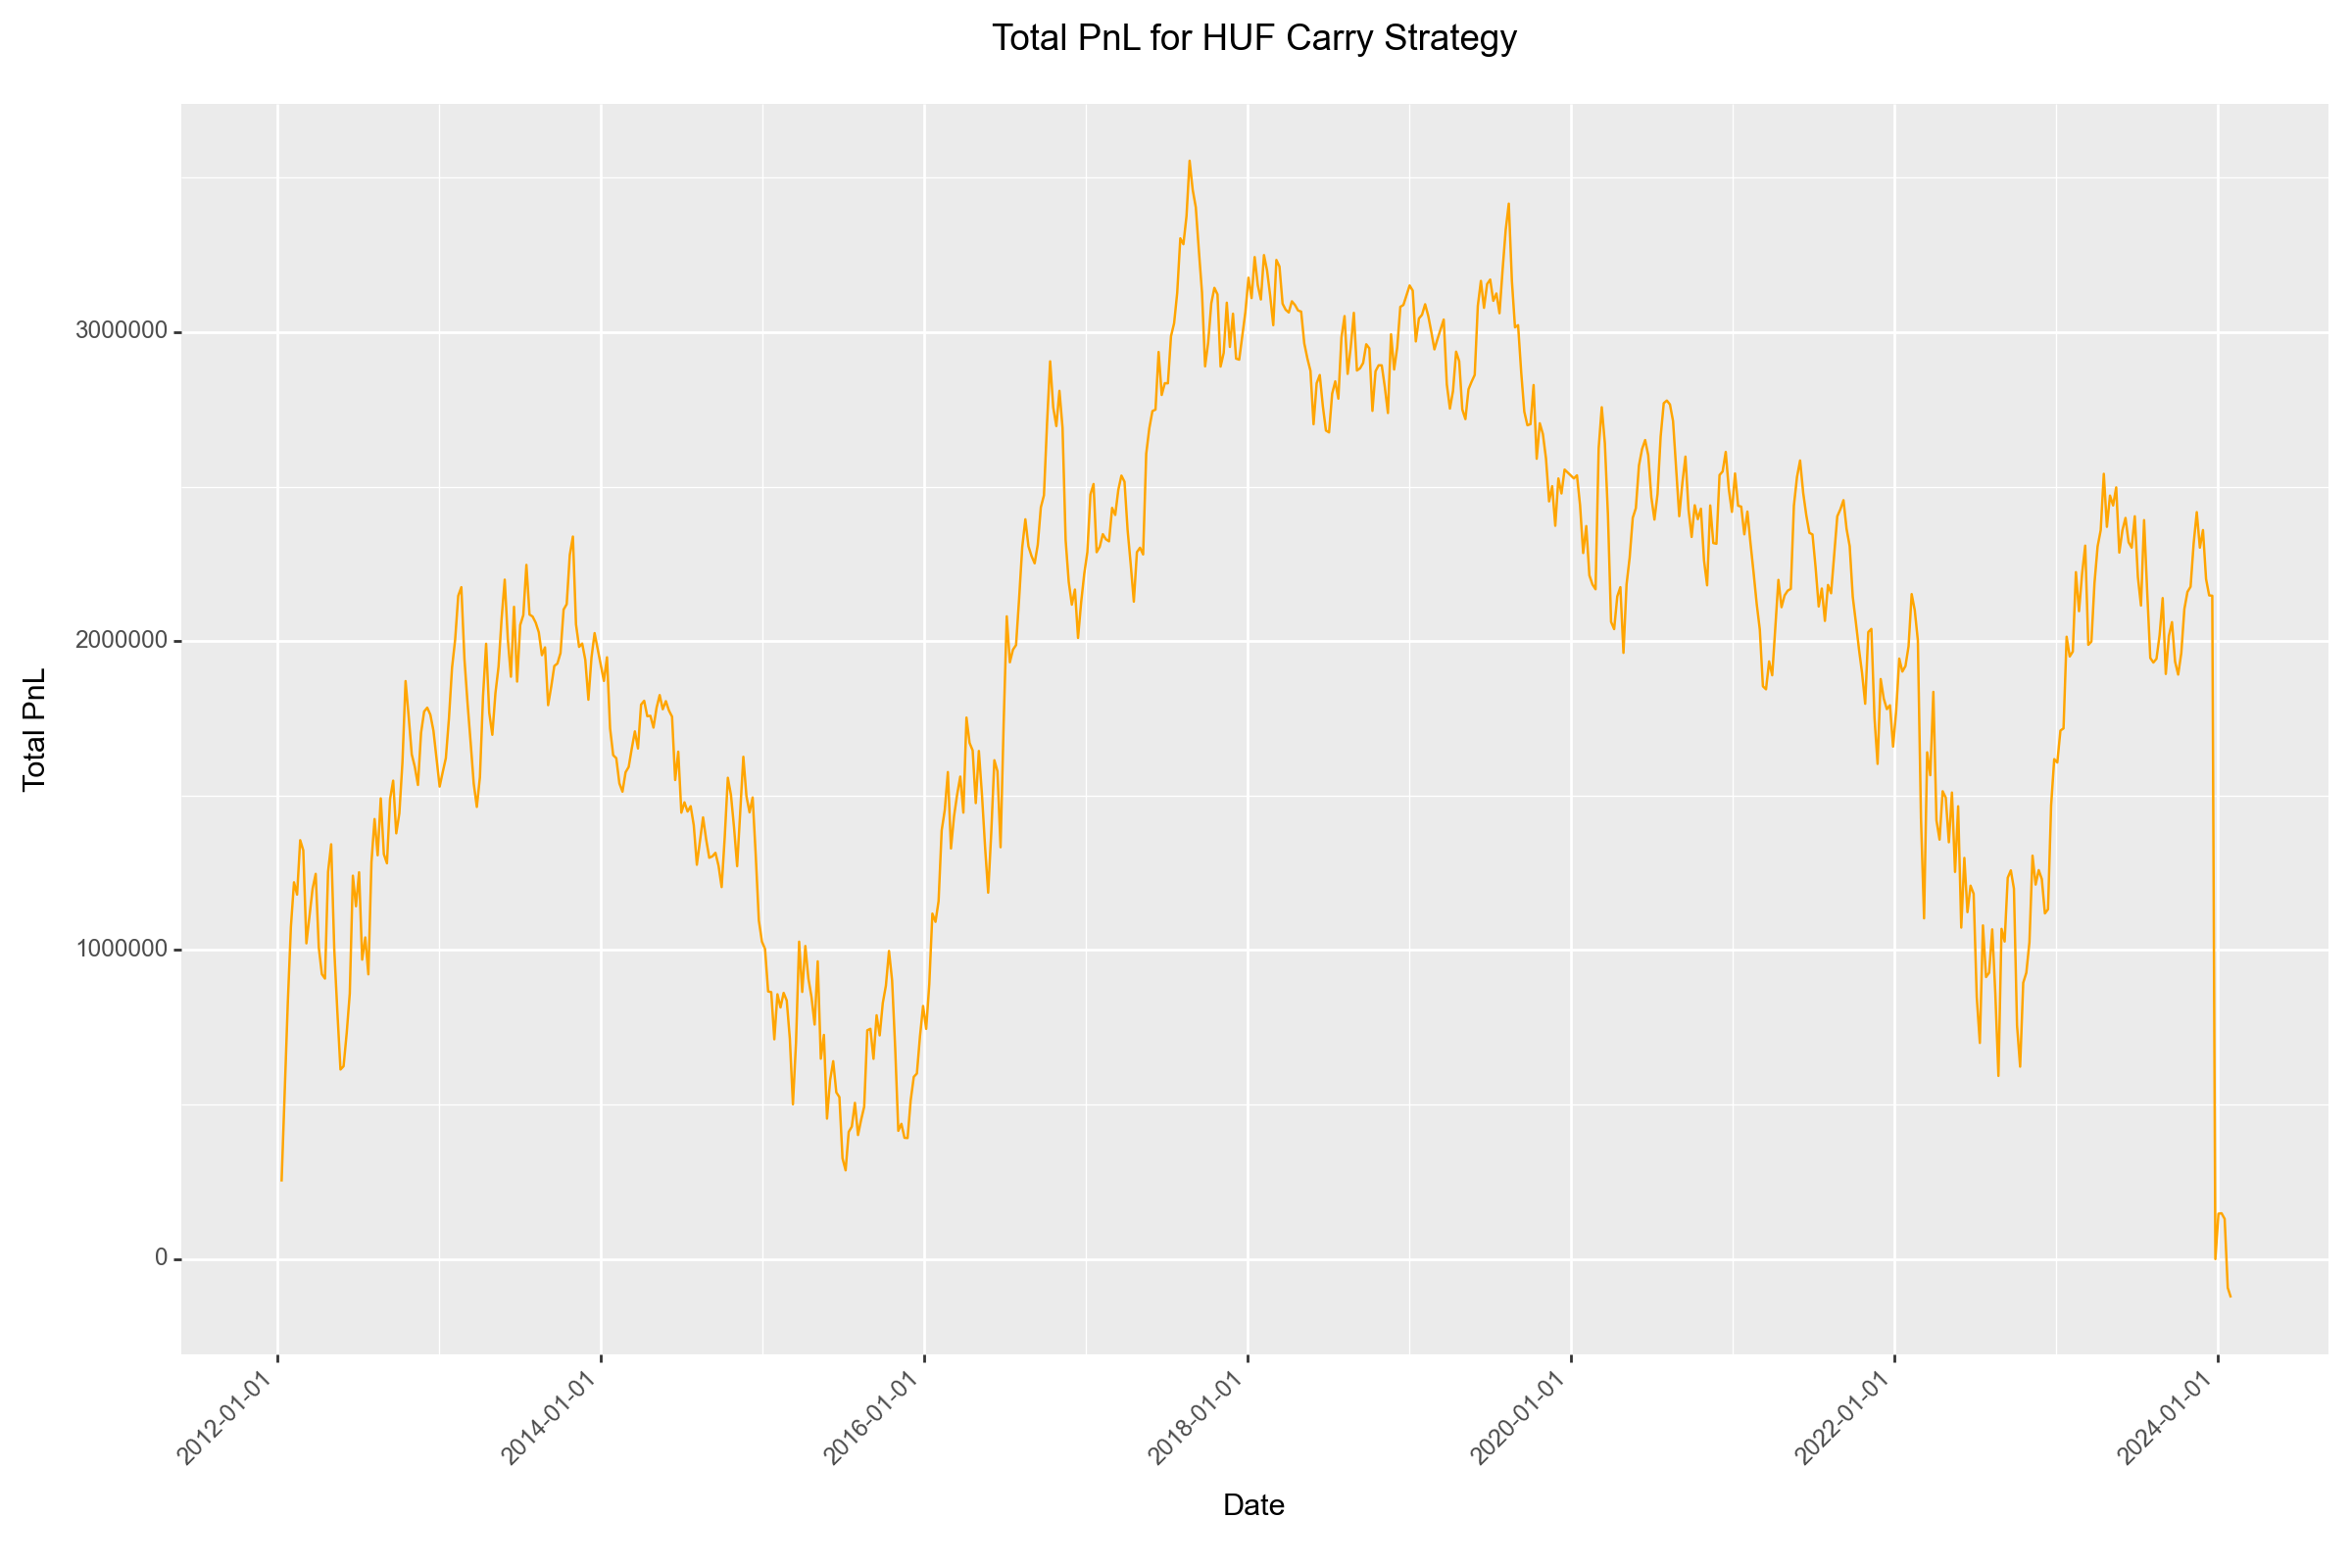

In [541]:
HUF_pnl_plot = plot_carry_trade_pnl(HUF_strat_with_pnl, 'HUF')
HUF_pnl_plot.draw()

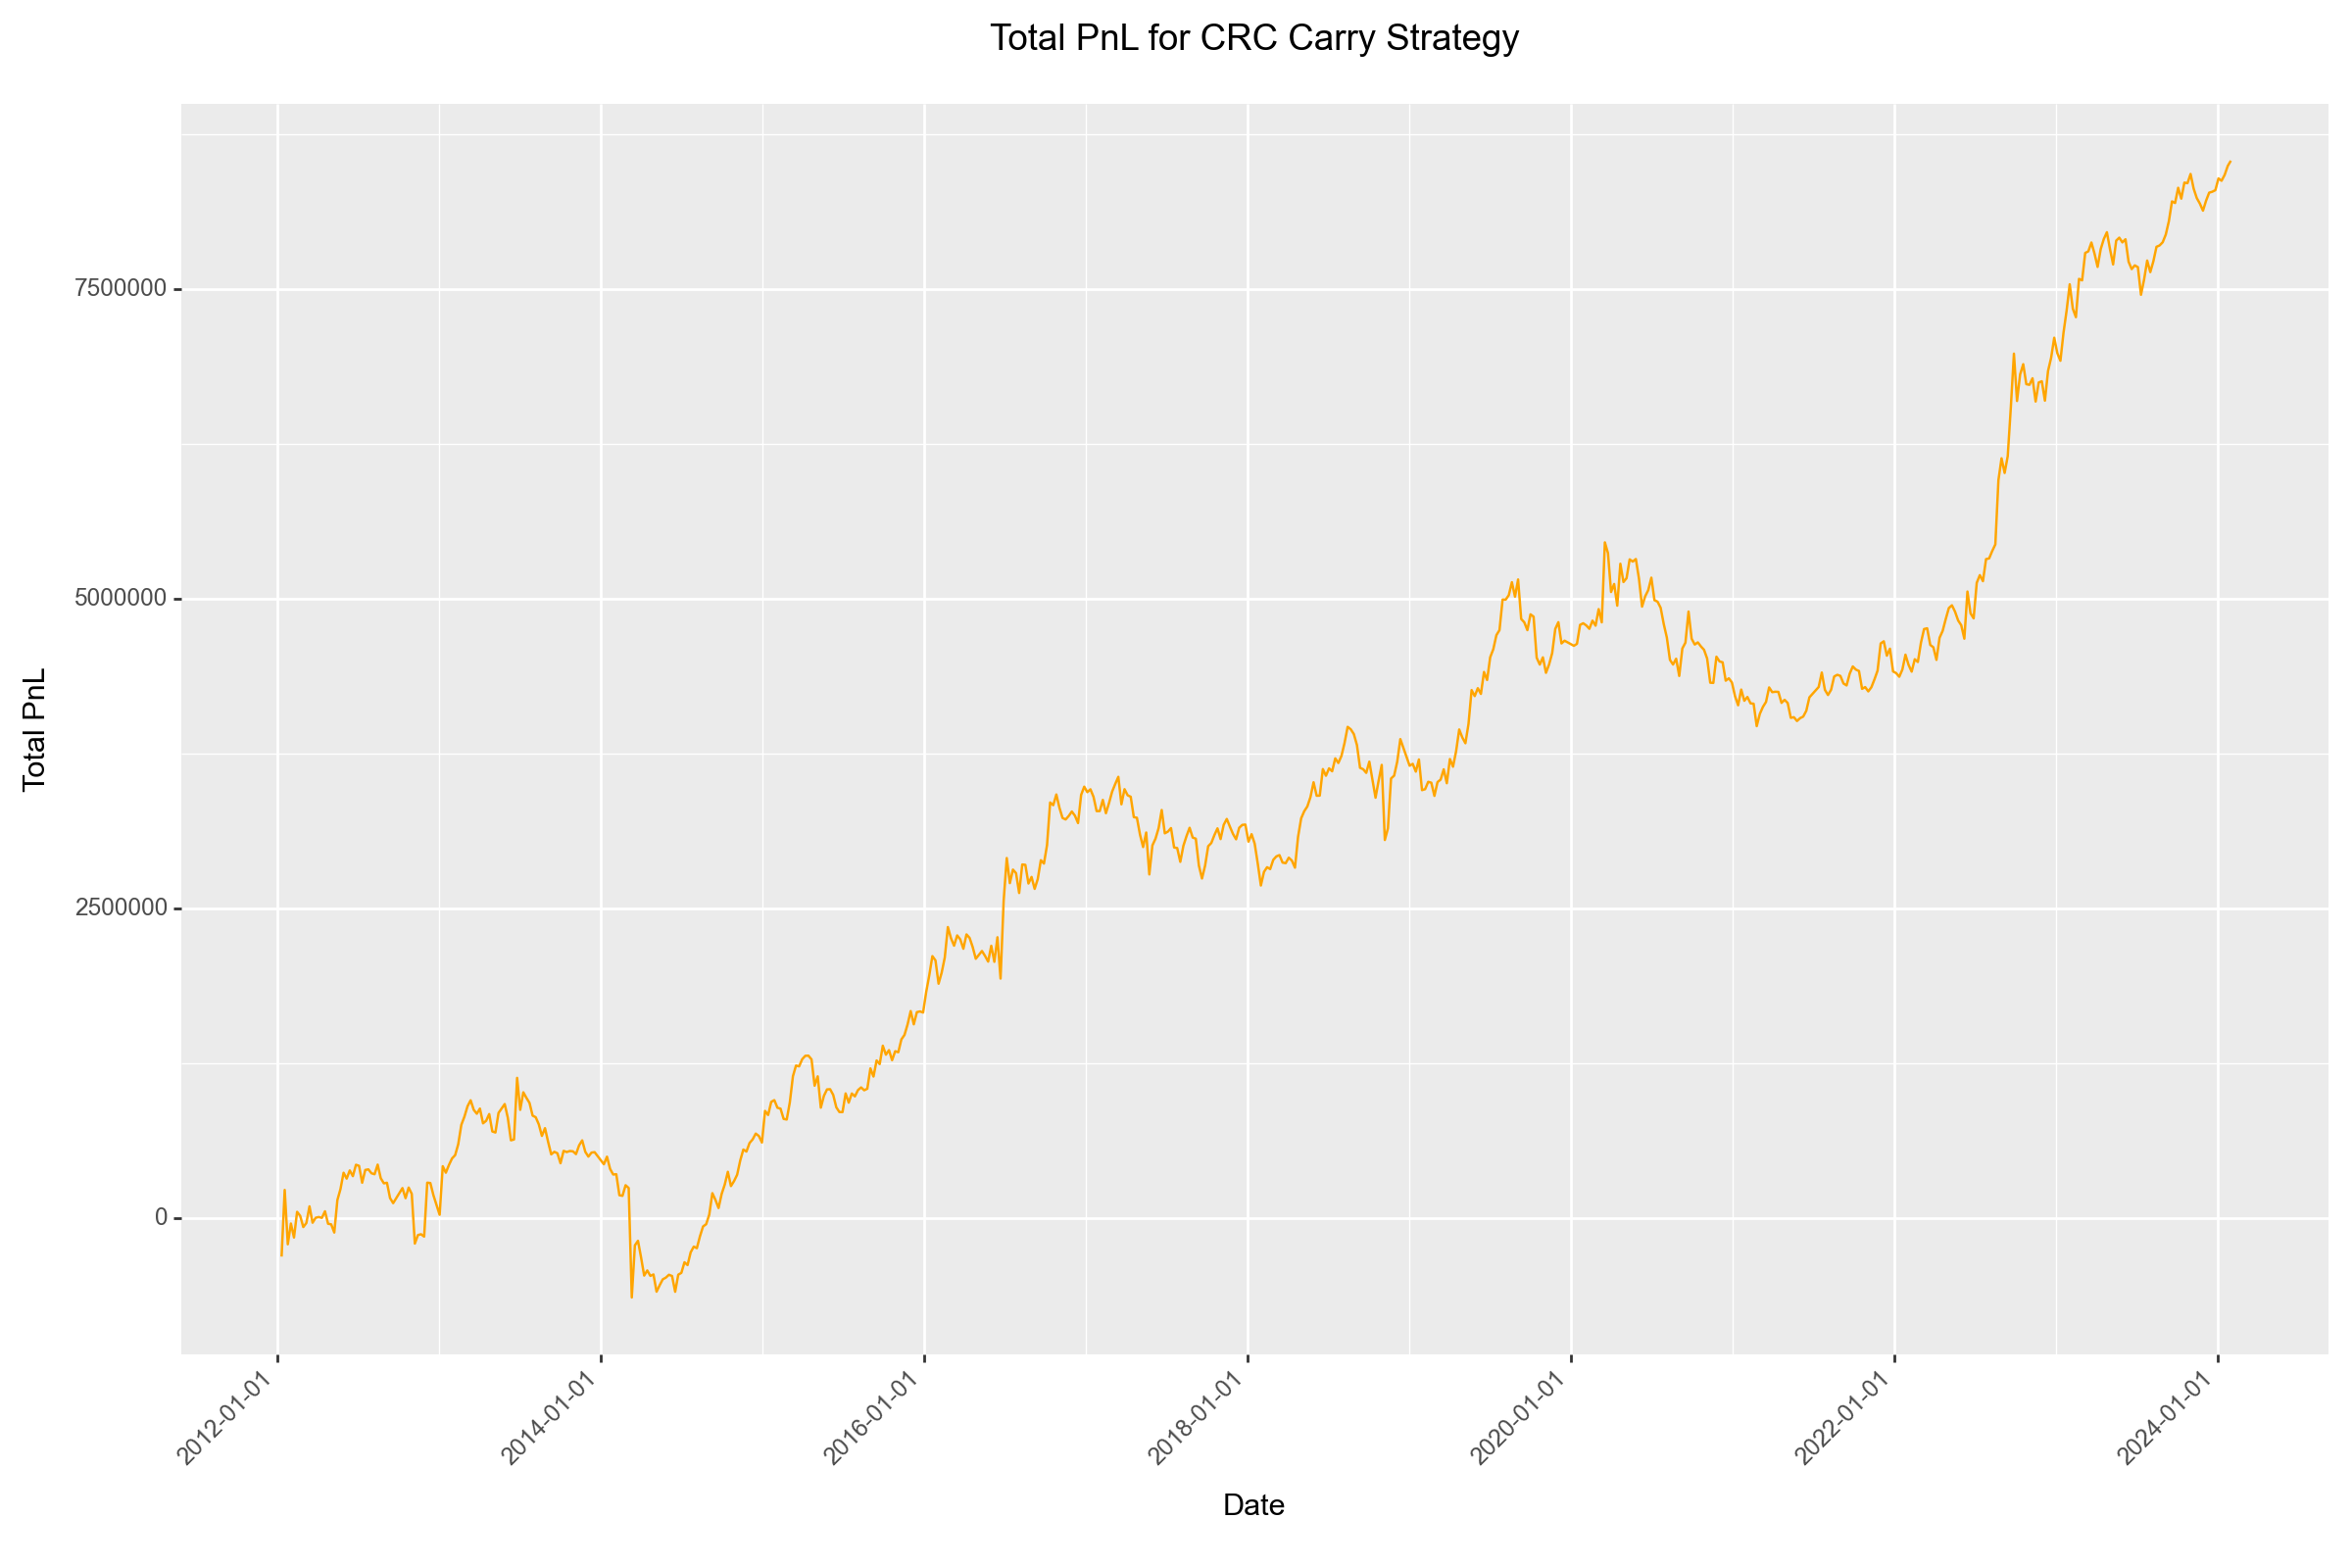

In [542]:
CRC_pnl_plot = plot_carry_trade_pnl(CRC_strat_with_pnl, 'CRC')
CRC_pnl_plot.draw()

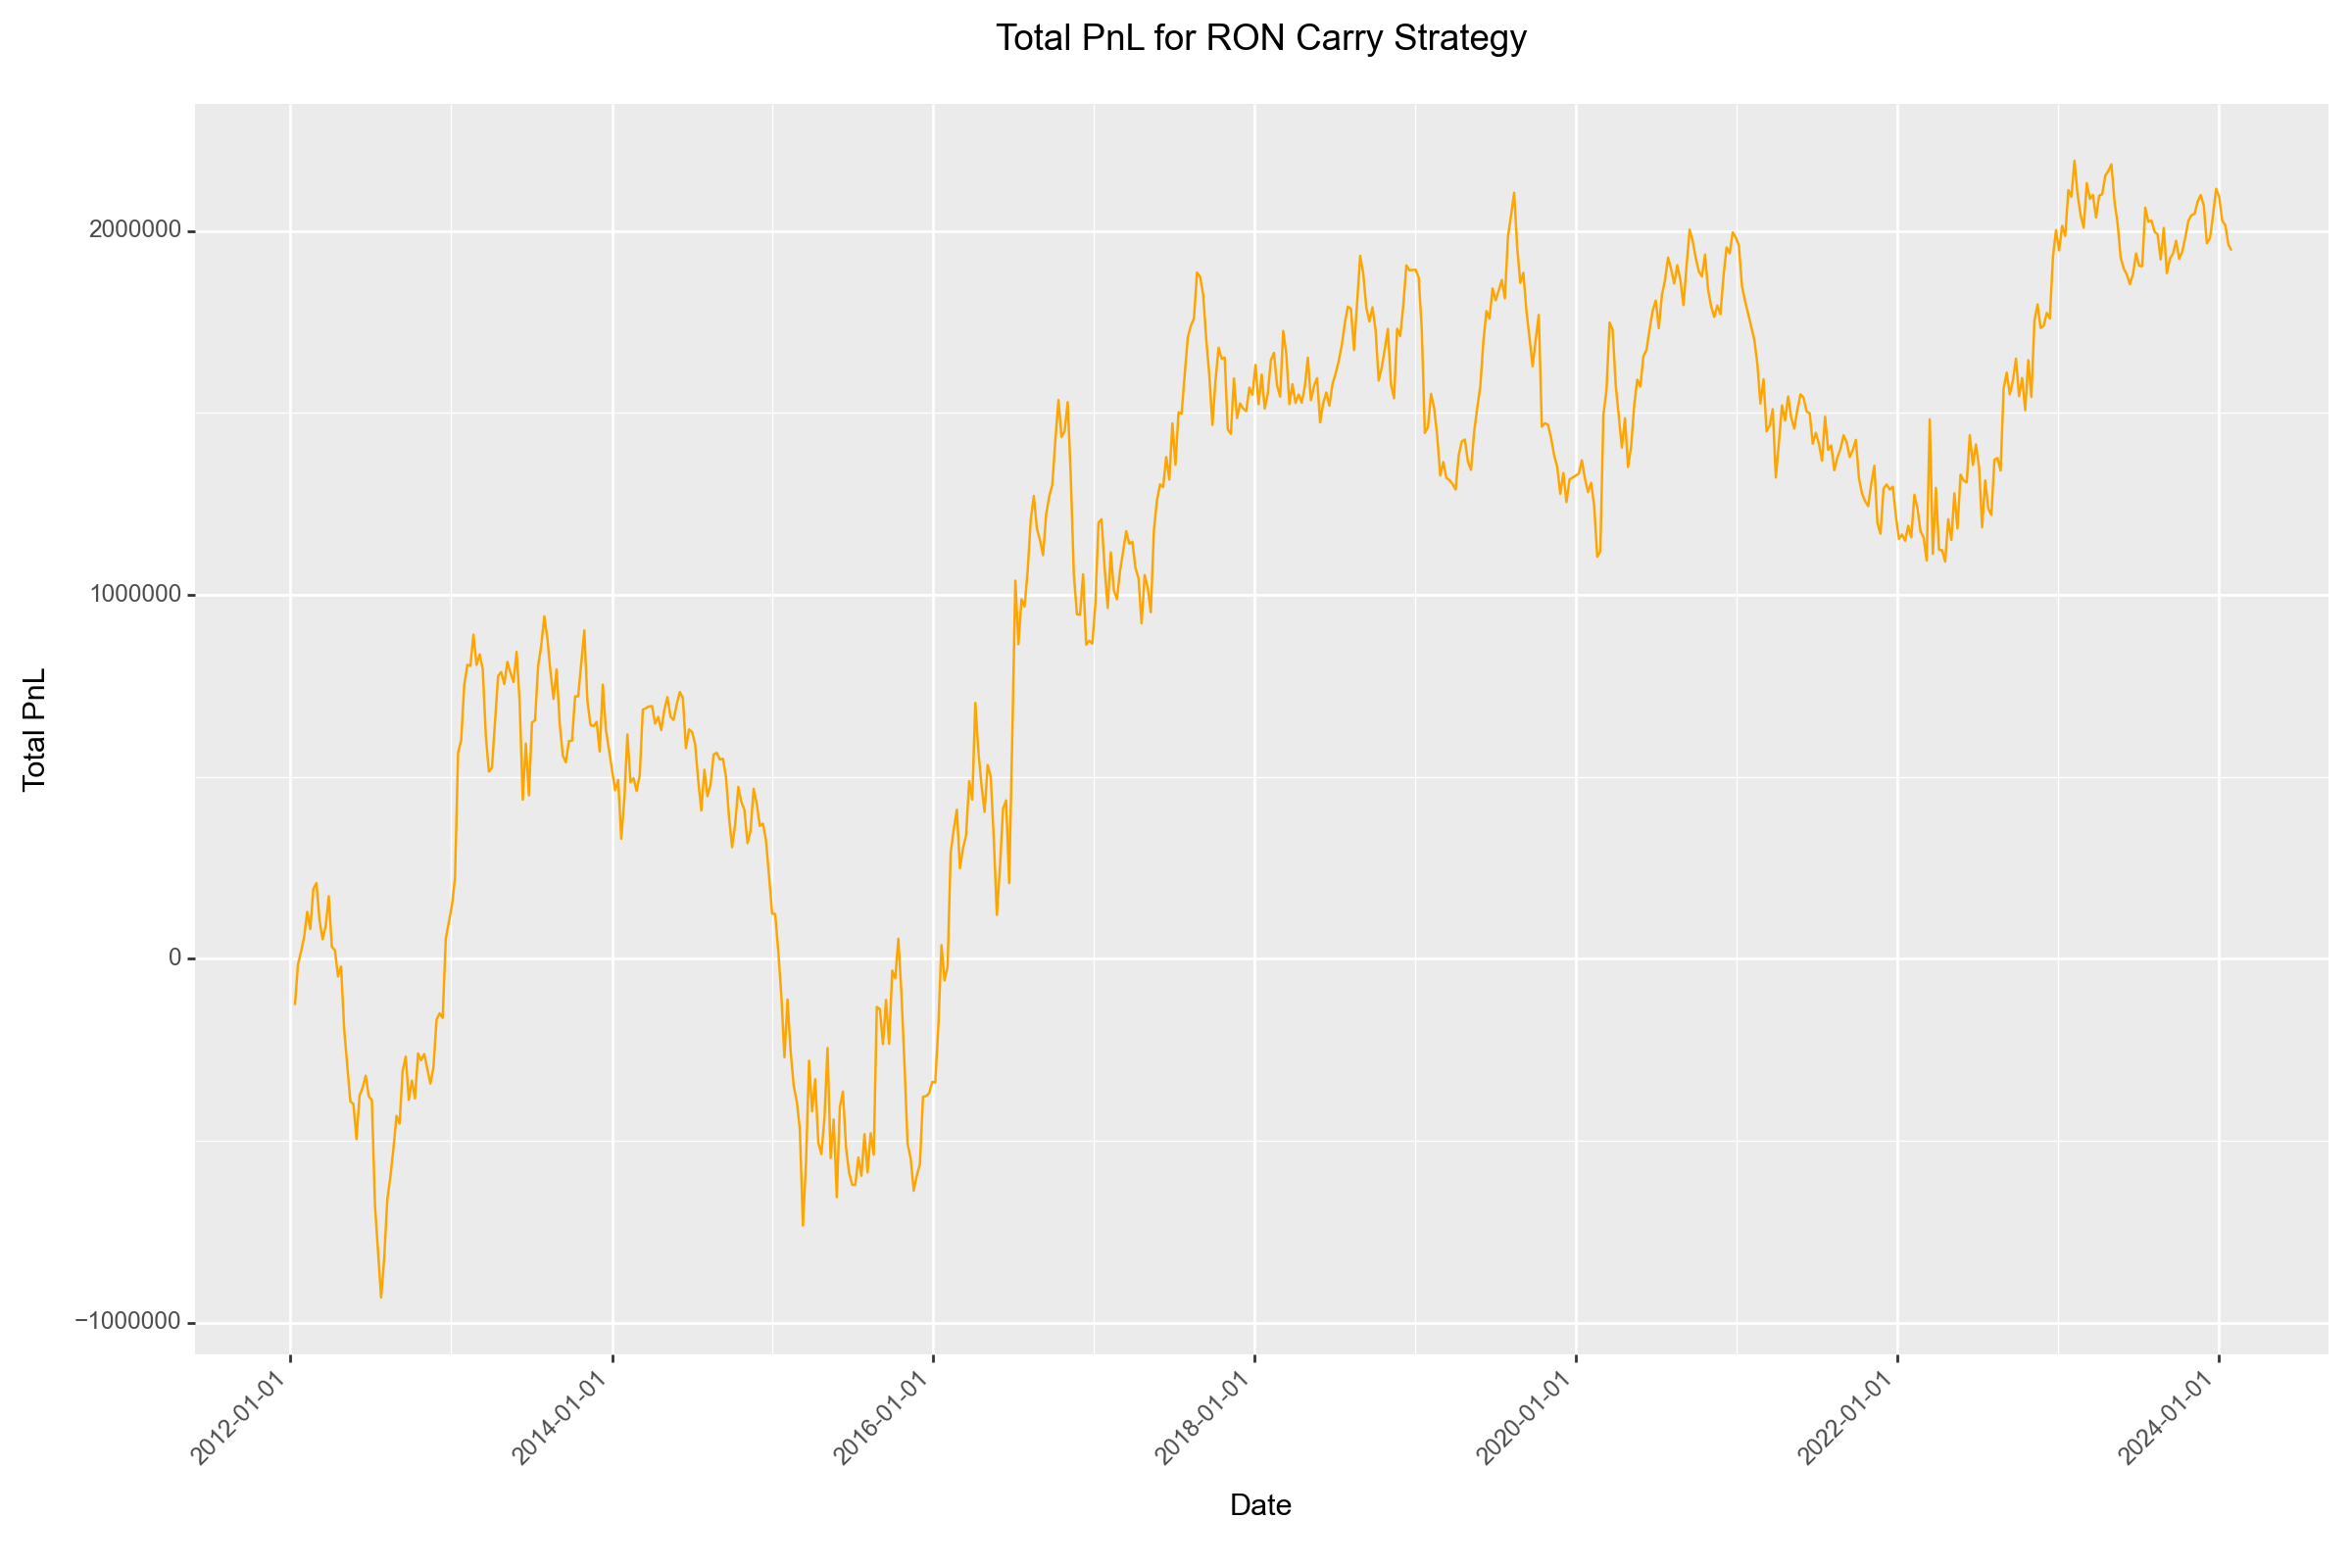

In [543]:
RON_pnl_plot = plot_carry_trade_pnl(RON_strat_with_pnl, 'RON')
RON_pnl_plot.draw()

#### As we can see, there are some drastic fluctuations in the PnL of our carry trades, and we will specifically analyze why these huge changes occur. However, first note a few details about the graphs in general. We expect carry trades to have steady, positive growth for the majority of the time, with a rapid decrease in overall PnL when outlier events occur (we will address some of these specific outlier events later). We definitely see this as the case in the EGP PnL plot. However, CRC really only sees a sharp increase in PnL over the entire period, and HUF/RON have a reverse directionality where there is a sharp increase in PnL rather than a sharp decrease. It is important to note these instances so that we can examine where they happen and postulate why they occur. With those observations, let us first explore the EGP currency and try to discover where the problem areas arise.

#### Notice above that we see a sharp decline around November 2016. Specifically, this decline happens on 2016-11-09 due to a massive increase in the FX rate between the Egyptian pound and USD. We then see the FX rate go down slightly the next day, which helps with our loss, but the FX rate quickly stabilizes at locks in our massive PnL loss. 

In [556]:
zoom_start = pd.to_datetime('2016-10-01')
zoom_end = pd.to_datetime('2017-01-01')

zoomed_EGP_df = EGP_strat_with_pnl[(EGP_strat_with_pnl.index >= zoom_start) & 
                                   (EGP_strat_with_pnl.index <= zoom_end)].copy()

zoomed_EGP_df

,EGP_5Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate,weekly_pnl,cumulative_pnl
2016-10-05,0.075458,8.875052,0.075561,0.002104,0.784300,1.624113e+05,9.656105e+05
2016-10-12,0.075472,8.874271,0.075564,0.002174,0.818030,3.437458e+05,1.309356e+06
2016-10-19,0.074771,8.877977,0.074864,0.002136,0.814335,-2.617853e+04,1.283178e+06
2016-10-26,0.075623,8.875079,0.075696,0.002105,0.821830,8.764375e+04,1.370822e+06
2016-11-02,0.074807,8.875540,0.074849,0.002082,0.812540,-7.879375e+04,1.292028e+06
2016-11-09,0.076174,17.354020,0.076113,0.002102,0.804188,-4.965449e+06,-3.673421e+06
2016-11-16,0.079503,15.524960,0.079440,0.002103,0.803048,1.177280e+06,-2.496142e+06
2016-11-23,0.078556,17.493380,0.078008,0.002119,0.802678,-1.132912e+06,-3.629053e+06
2016-11-30,0.078105,17.849340,0.077244,0.002024,0.800568,-2.188830e+05,-3.847936e+06
2016-12-07,0.077516,18.096510,0.076778,0.002118,0.793580,-1.875653e+05,-4.035502e+06


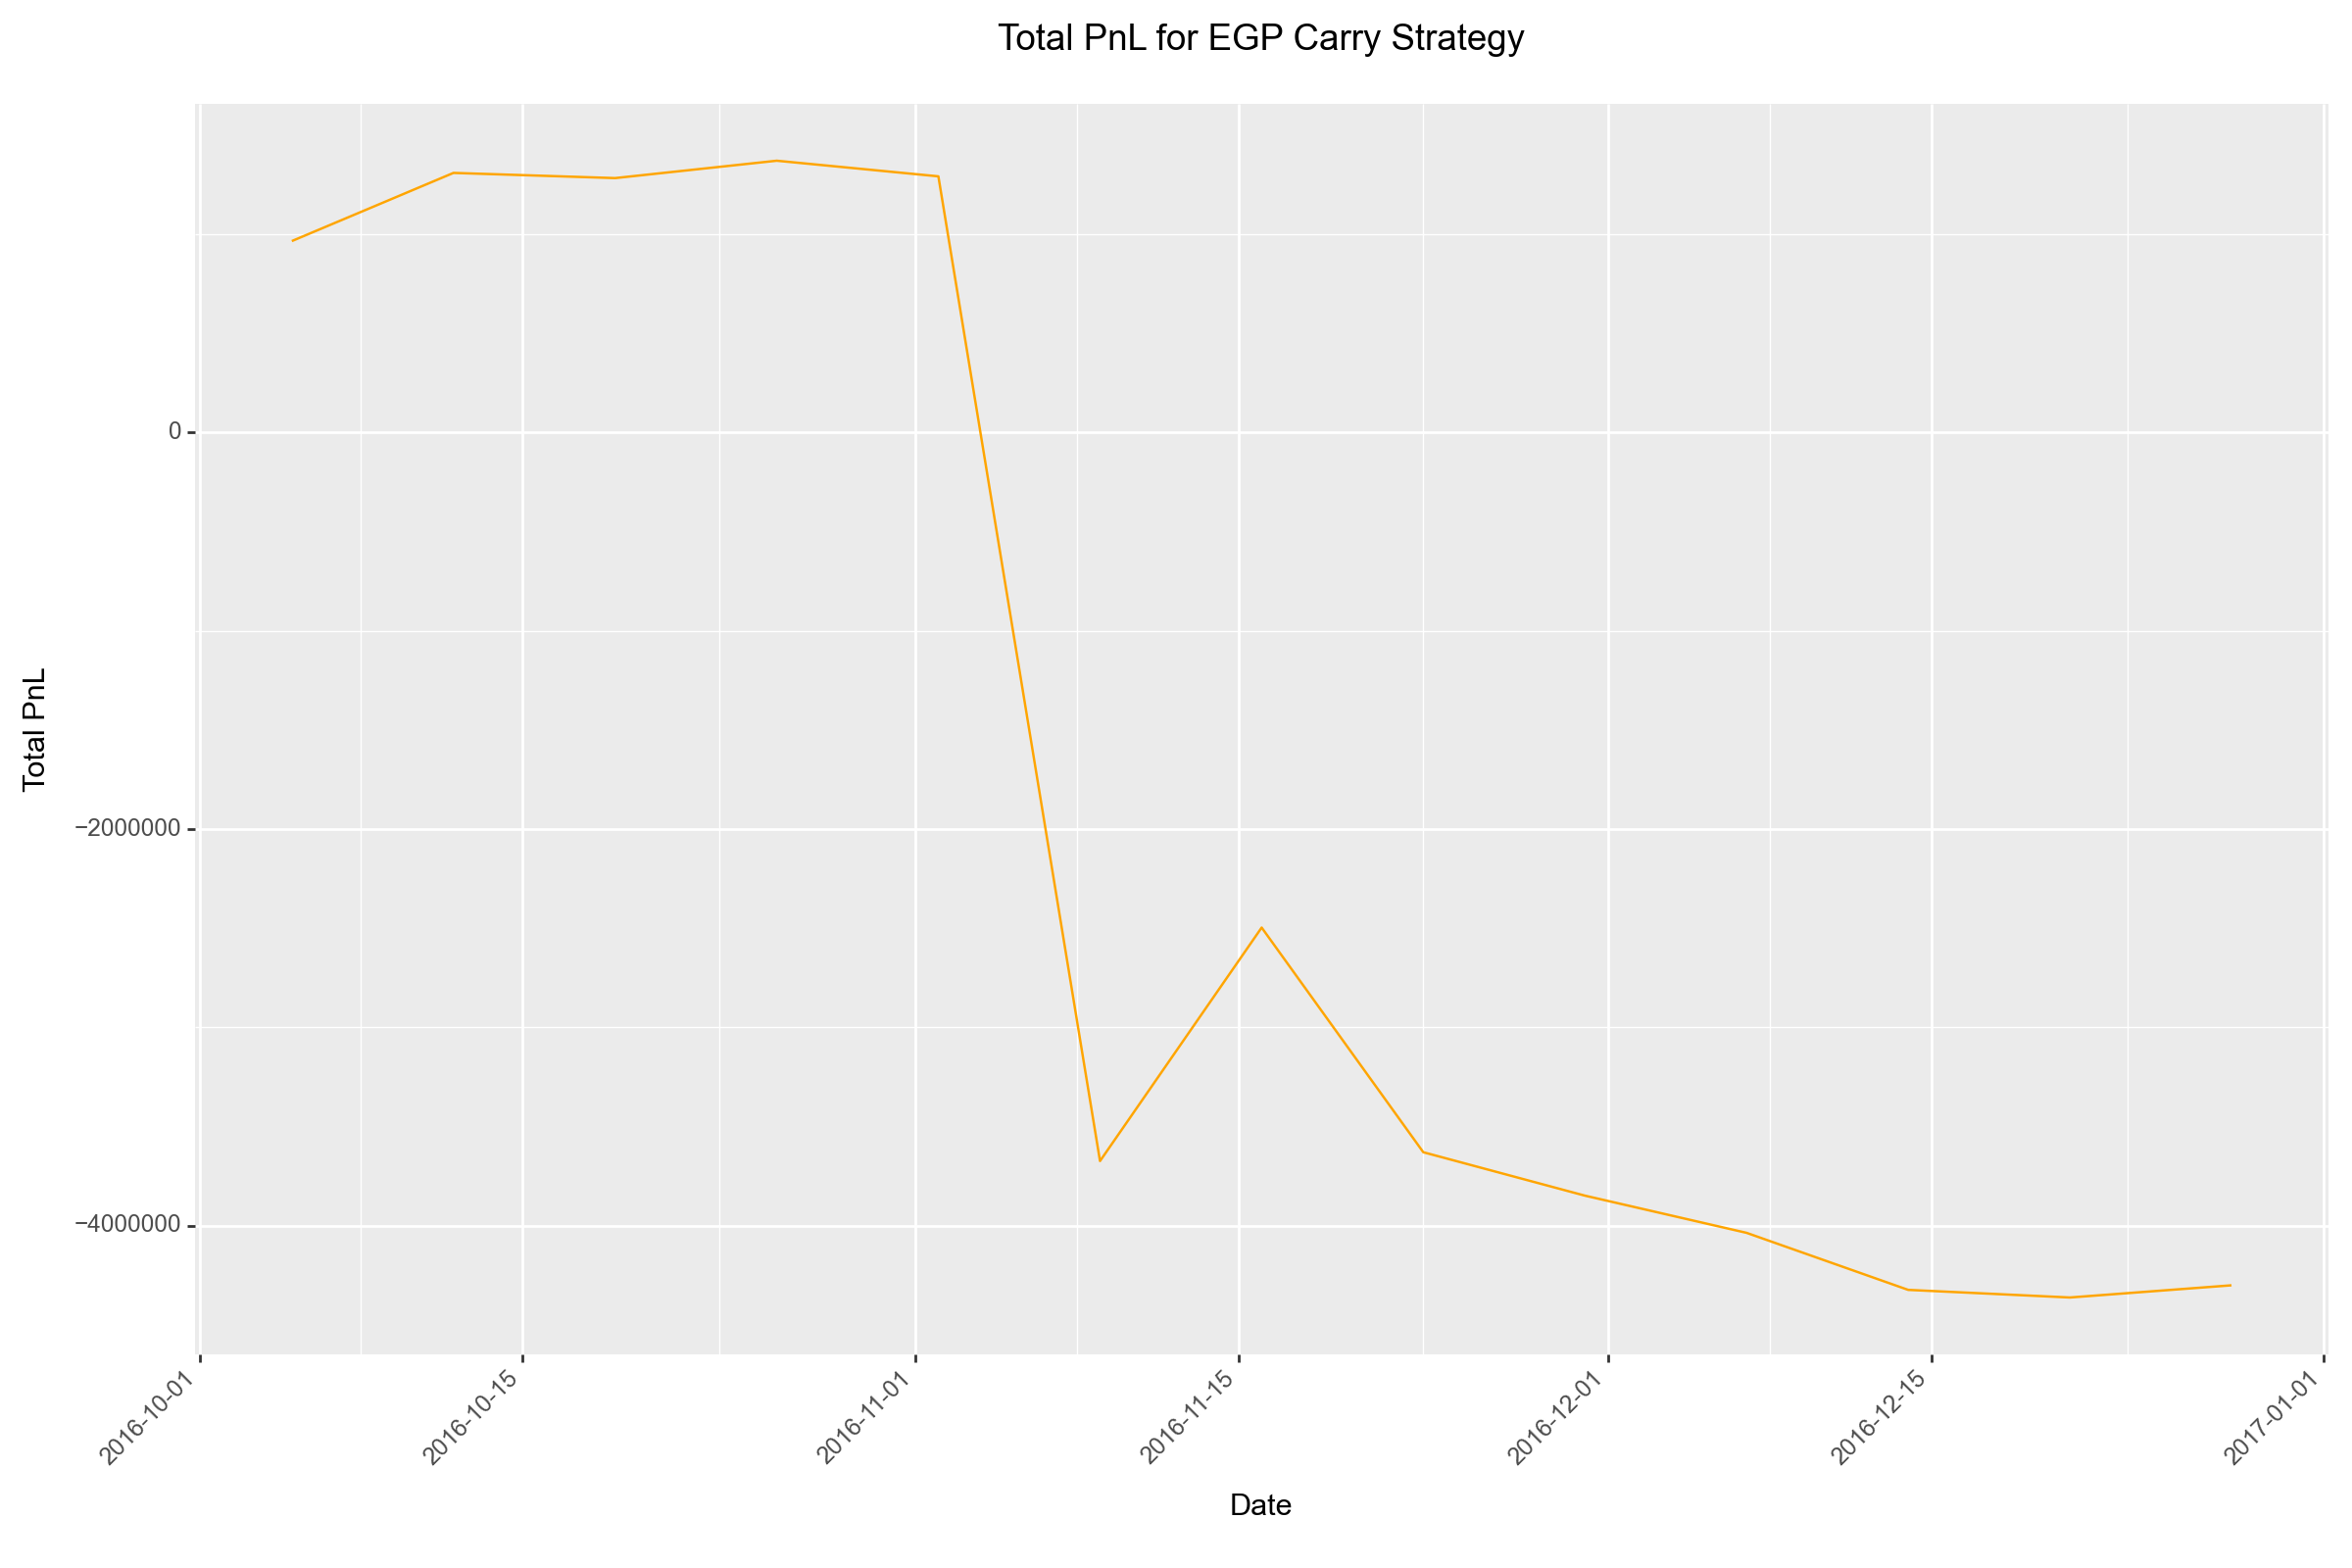

In [557]:
zoomed_EGP_pnl_plot = plot_carry_trade_pnl(zoomed_EGP_df, 'EGP')

zoomed_EGP_pnl_plot.draw()

#### Similarly, if we examine the period towards the end of our testing period, there is another sharp decline in the PnL of our strategy when using EGP. If we had to guess why this occurred, we can assume that it was likely due to another drastic increase in the overall FX rate between EGP and USD. Let us examine this time frame to confirm. 

In [565]:
second_zoom_start = pd.to_datetime('2022-10-01')
second_zoom_end = pd.to_datetime('2023-03-01')

second_zoomed_EGP_df = EGP_strat_with_pnl[(EGP_strat_with_pnl.index >= second_zoom_start) & 
                                   (EGP_strat_with_pnl.index <= second_zoom_end)].copy()

second_zoomed_EGP_df

,EGP_5Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate,weekly_pnl,cumulative_pnl
2022-10-05,0.194647,19.662500,0.209535,0.021866,0.874692,-6.227191e+05,1.049293e+05
2022-10-12,0.199576,19.682700,0.218566,0.021860,0.909347,4.339844e+05,5.389137e+05
2022-10-19,0.198560,19.657800,0.219846,0.021843,0.882969,-1.207202e+05,4.181935e+05
2022-10-26,0.183502,19.707400,0.193295,0.021852,0.873146,-3.744915e+05,4.370204e+04
2022-11-02,0.187173,24.204000,0.195269,0.021859,0.868741,-1.925186e+06,-1.881484e+06
2022-11-09,0.184995,24.331330,0.191112,0.029263,0.866886,-9.336914e+04,-1.974854e+06
2022-11-16,0.151709,24.428100,0.153842,0.029265,0.842385,-2.917297e+05,-2.266583e+06
2022-11-23,0.150498,24.508300,0.152182,0.029271,0.841310,-3.184367e+04,-2.298427e+06
2022-11-30,0.141992,24.555700,0.142593,0.029273,0.834749,-7.854865e+04,-2.376976e+06
2022-12-07,0.143143,24.595500,0.144936,0.029275,0.824453,-5.467300e+04,-2.431649e+06


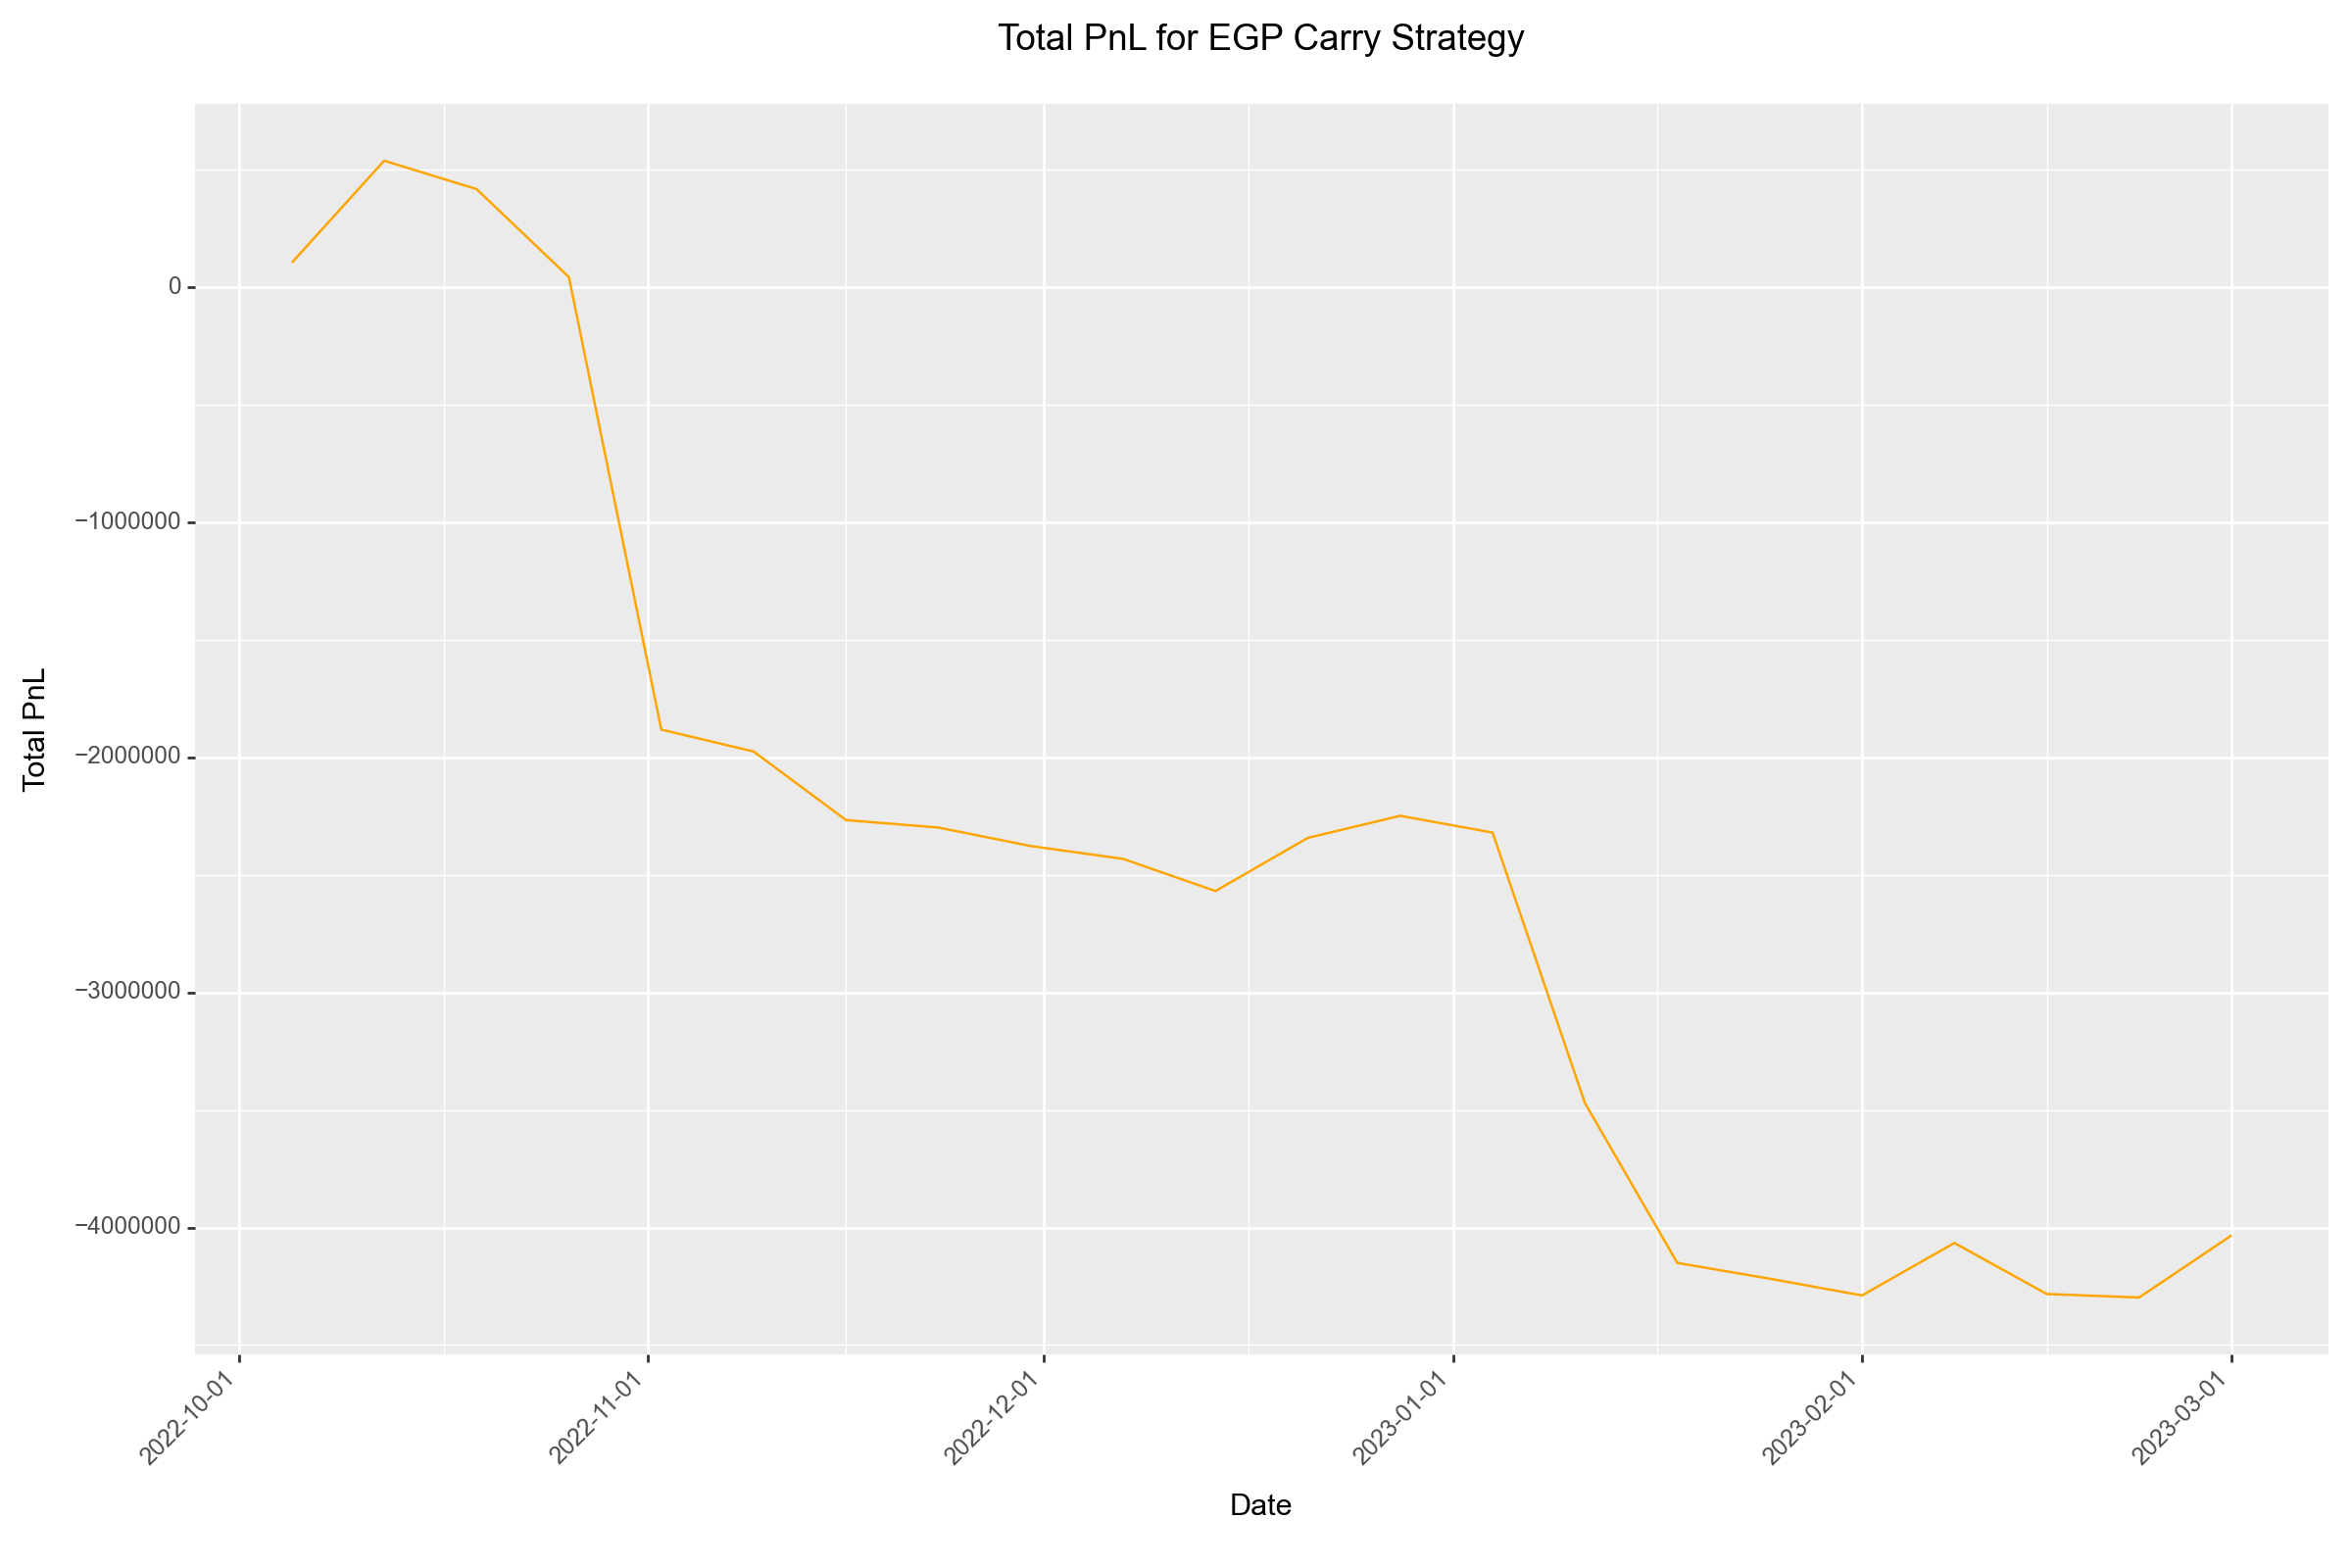

In [566]:
second_zoomed_EGP_pnl_plot = plot_carry_trade_pnl(second_zoomed_EGP_df, 'EGP')

second_zoomed_EGP_pnl_plot.draw()

#### Indeed, when looking at the dataframe we do see a sharp increase in the FX rate on 2022-11-02 and 2023-01-11 that causes these massive drops in PnL. Now that we have made sense of these giant PnL drawdowns for EGP, let us see if this same reasoning applies to the HUF drop at the end of the testing period. After that, let's analyze the risk metrics of these two plots and try to derive a way to avoid such a tremendous loss if the FX spike were to occur.

In [600]:
def calculate_risk_metrics(strat_df, confidence_level=0.95):

    risk_df = strat_df.copy()
    risk_df.dropna(inplace=True)

    # Maximum Drawdown
    prev_high = 0
    max_drawdown = 0
    for i, tot_pnl in risk_df.itertuples():
        prev_high = max(prev_high, tot_pnl)
        dd = tot_pnl - prev_high
        if dd < max_drawdown:
            max_drawdown = dd
    
    # Value at Risk (VaR) - Assuming normal distribution for simplicity
    var = np.percentile(risk_df, (1 - confidence_level) * 100)
    
    # Conditional Value at Risk (CVaR) - Average of losses worse than VaR
    cvar = float(risk_df[risk_df <= var].mean())
    
    sharpe = float(risk_df.mean()/risk_df.std())
    
    # Prepare the result DataFrame
    risk_metrics = pd.DataFrame({
        'Metric': ['Maximum Drawdown', 'VaR', 'CVaR', 'Sharpe Ratio'],
        'Value': [max_drawdown, var, cvar, sharpe]
    })
    
    risk_metrics.set_index('Metric', inplace=True)
    
    return risk_metrics

In [601]:
EGP_risk_metrics = calculate_risk_metrics(EGP_strat_with_pnl['cumulative_pnl'].to_frame())
EGP_risk_metrics

,Value
Metric,
Maximum Drawdown,-5.861497e+06
VaR,-3.889339e+06
CVaR,-4.185215e+06
Sharpe Ratio,-8.037513e-01


In [602]:
HUF_risk_metrics = calculate_risk_metrics(HUF_strat_with_pnl['cumulative_pnl'].to_frame())
HUF_risk_metrics

,Value
Metric,
Maximum Drawdown,-3.679179e+06
VaR,6.265979e+05
CVaR,3.968342e+05
Sharpe Ratio,2.570595e+00


#### From these two risk data frames, we see that the maximum drawdown for both of them is incredibly steep. Despite the attractive looking Sharpe ratio of the HUF strategy, we see that our maximum drawdown essentially wipes away all of our PnL. This is what we would expect from a carry strategy, as we have captured a premium from holding risk over time, but when the tail events eventually happen, we are left with incredible exposure to downside potential. This is not as obvious from the EGP strategy since the Sharpe ratio is negative, but we can still see from the EGP PnL plot that our massive drawdowns are caused by huge FX rate changes, which only happen sporadically. 

#### If we wanted one straight carry trade, then this downside potential is just a necessary risk that we have to accept. However, if we are willing to implement all the strategies together, we can counteract some of the issues that arise from these one-off events. This of course opens us up to less overall PnL gain, but it also helps us to avoid these massive drawdowns that occur when we focus on one currency. Let us investigate what happens if we combine all of these trades together. Firstly, we will verify that the correlations between the PnL columns would allow for sufficient diversification.

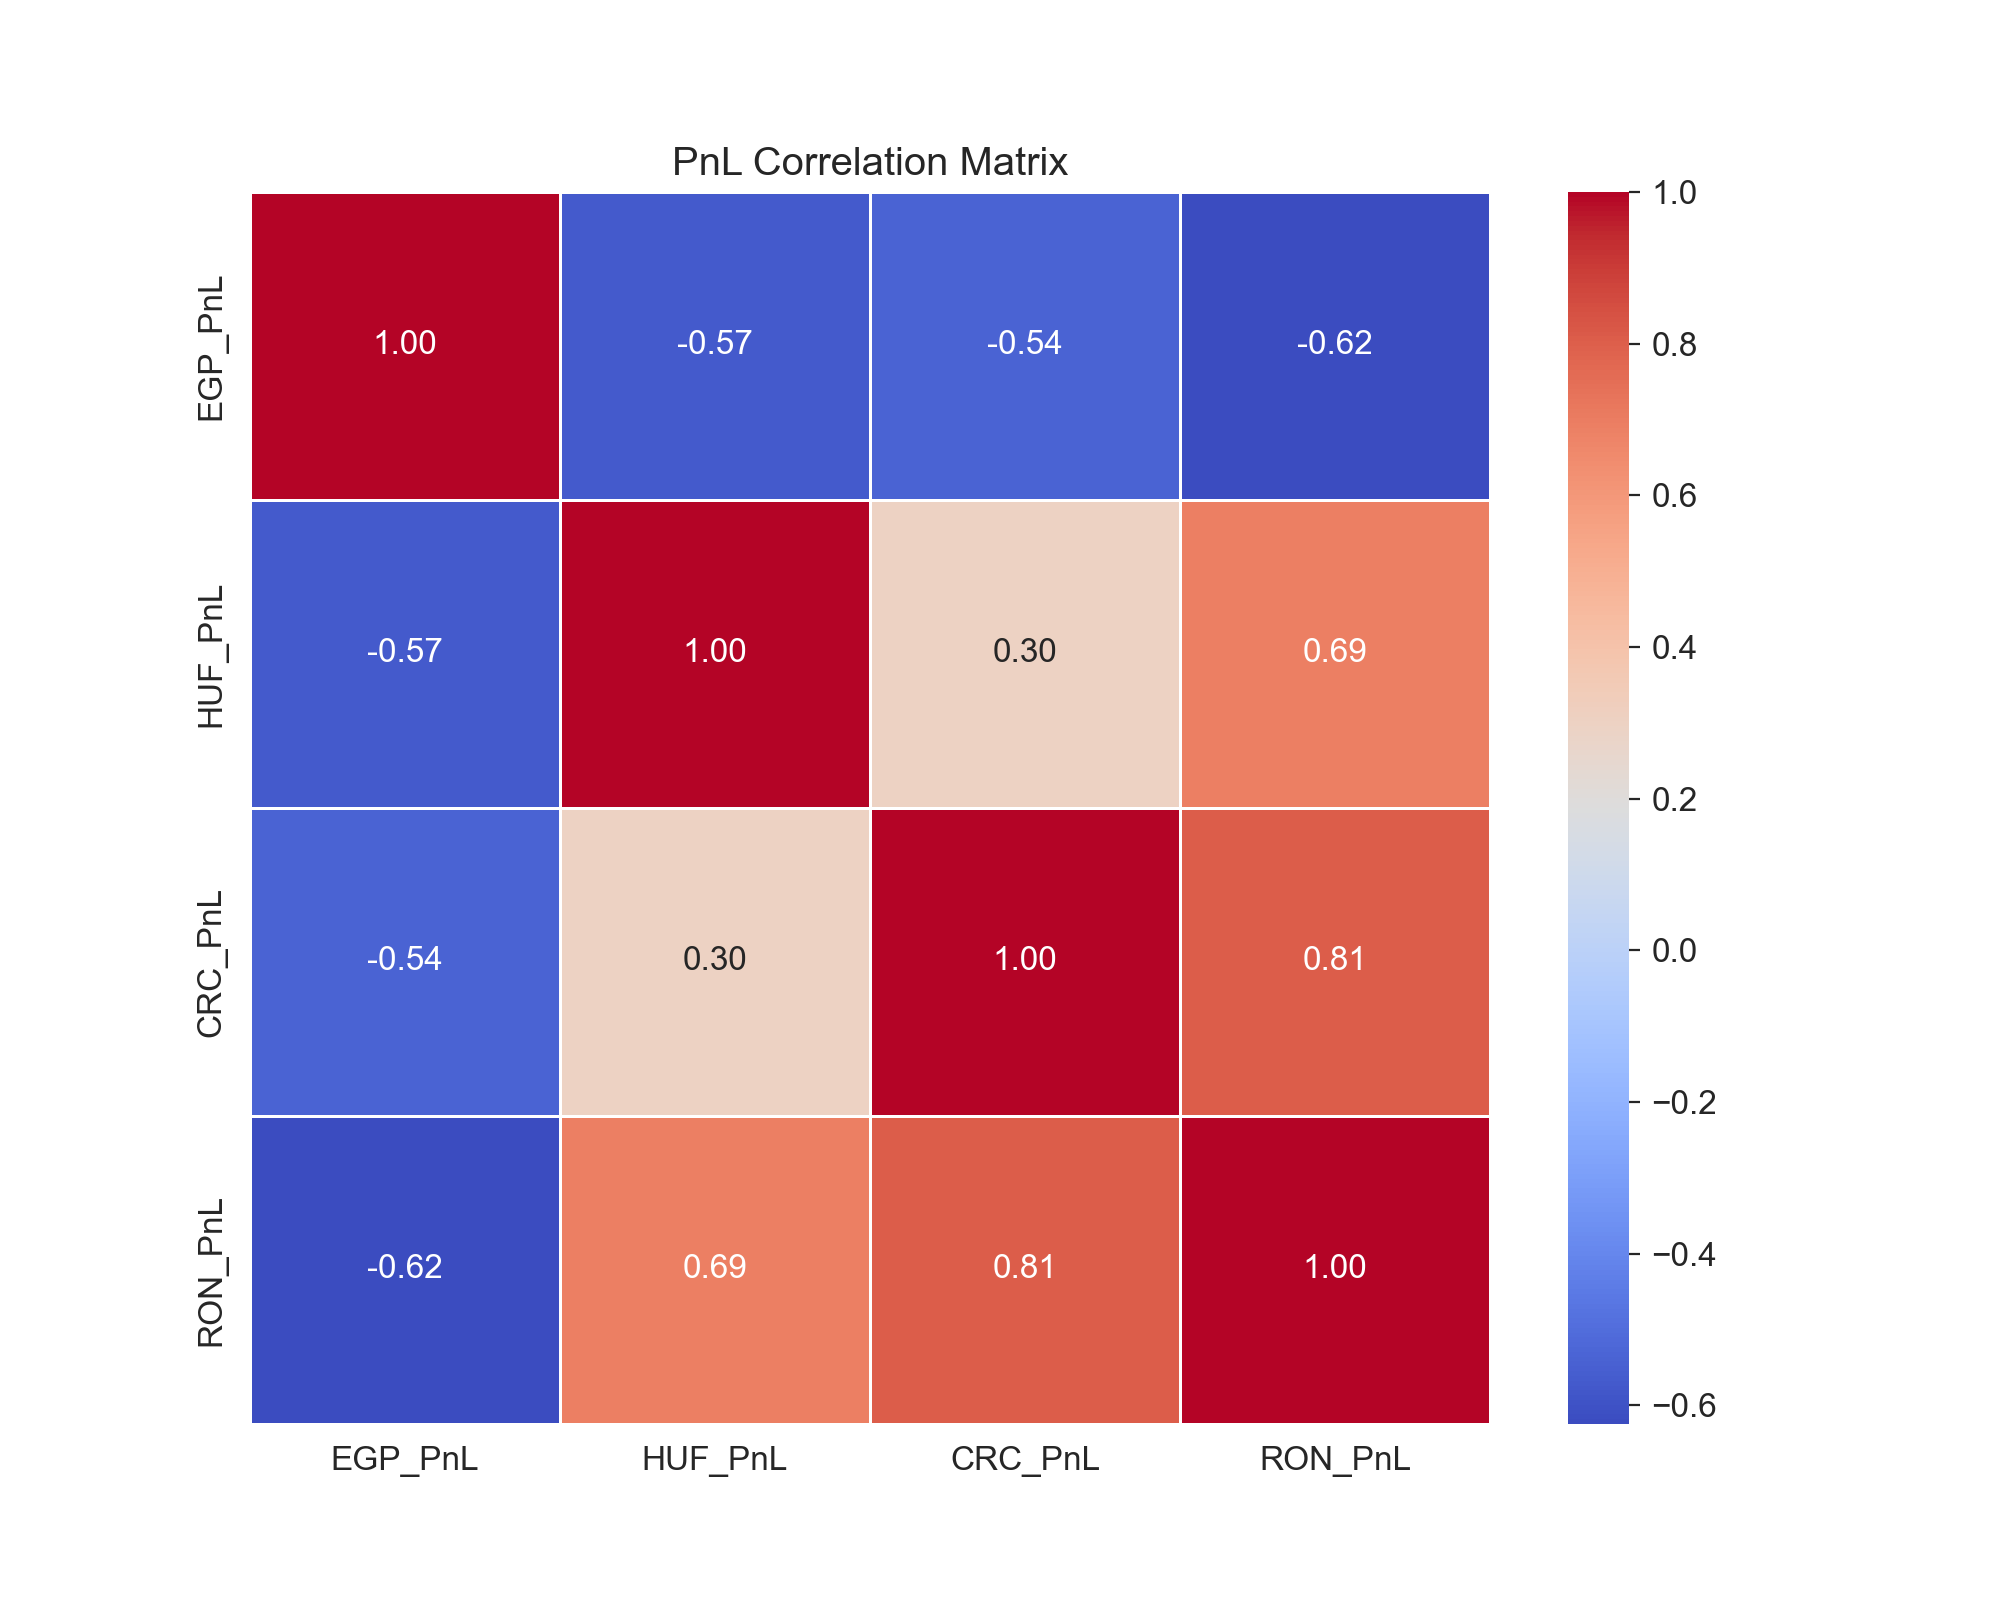

In [605]:
combined_pnl_df = pd.DataFrame({
    'EGP_PnL': EGP_strat_with_pnl['cumulative_pnl'],
    'HUF_PnL': HUF_strat_with_pnl['cumulative_pnl'],
    'CRC_PnL': CRC_strat_with_pnl['cumulative_pnl'],
    'RON_PnL': RON_strat_with_pnl['cumulative_pnl']
})

pnl_correlation_matrix = combined_pnl_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(pnl_correlation_matrix, annot=True, 
            cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

plt.title('PnL Correlation Matrix')
plt.show()

#### Unfortunately, these are not the near zero correlations that we would have hoped for to ensure proper diversification. However, these high correlations do make a lot of sense, especially since every single strategy has the exact same interest payment and loan change amount in GBP. Let us then only examine the changes in bond values against each other to see if this helps us with our diversification requirement. Note that this is a valid approach since the loan fluctuations and interest payments are *theoretically* independent of the bond values. Of course, the fluctuations in FX rates are NOT independent, but it is still valid to consider a combined strategy if we see bond values as uncorrelated.

In [607]:
EGP_pnl_with_cols = calc_pnl(EGP_strategy_data, 'EGP', False)
HUF_pnl_with_cols = calc_pnl(HUF_strategy_data, 'HUF', False)
CRC_pnl_with_cols = calc_pnl(CRC_strategy_data, 'CRC', False)
RON_pnl_with_cols= calc_pnl(RON_strategy_data, 'RON', False)

In [614]:
EGP_pnl_with_cols['bond_val'] = EGP_pnl_with_cols['new_bond_value_USD'] - 10_000_000
HUF_pnl_with_cols['bond_val'] = HUF_pnl_with_cols['new_bond_value_USD'] - 10_000_000
CRC_pnl_with_cols['bond_val'] = CRC_pnl_with_cols['new_bond_value_USD'] - 10_000_000
RON_pnl_with_cols['bond_val'] = RON_pnl_with_cols['new_bond_value_USD'] - 10_000_000

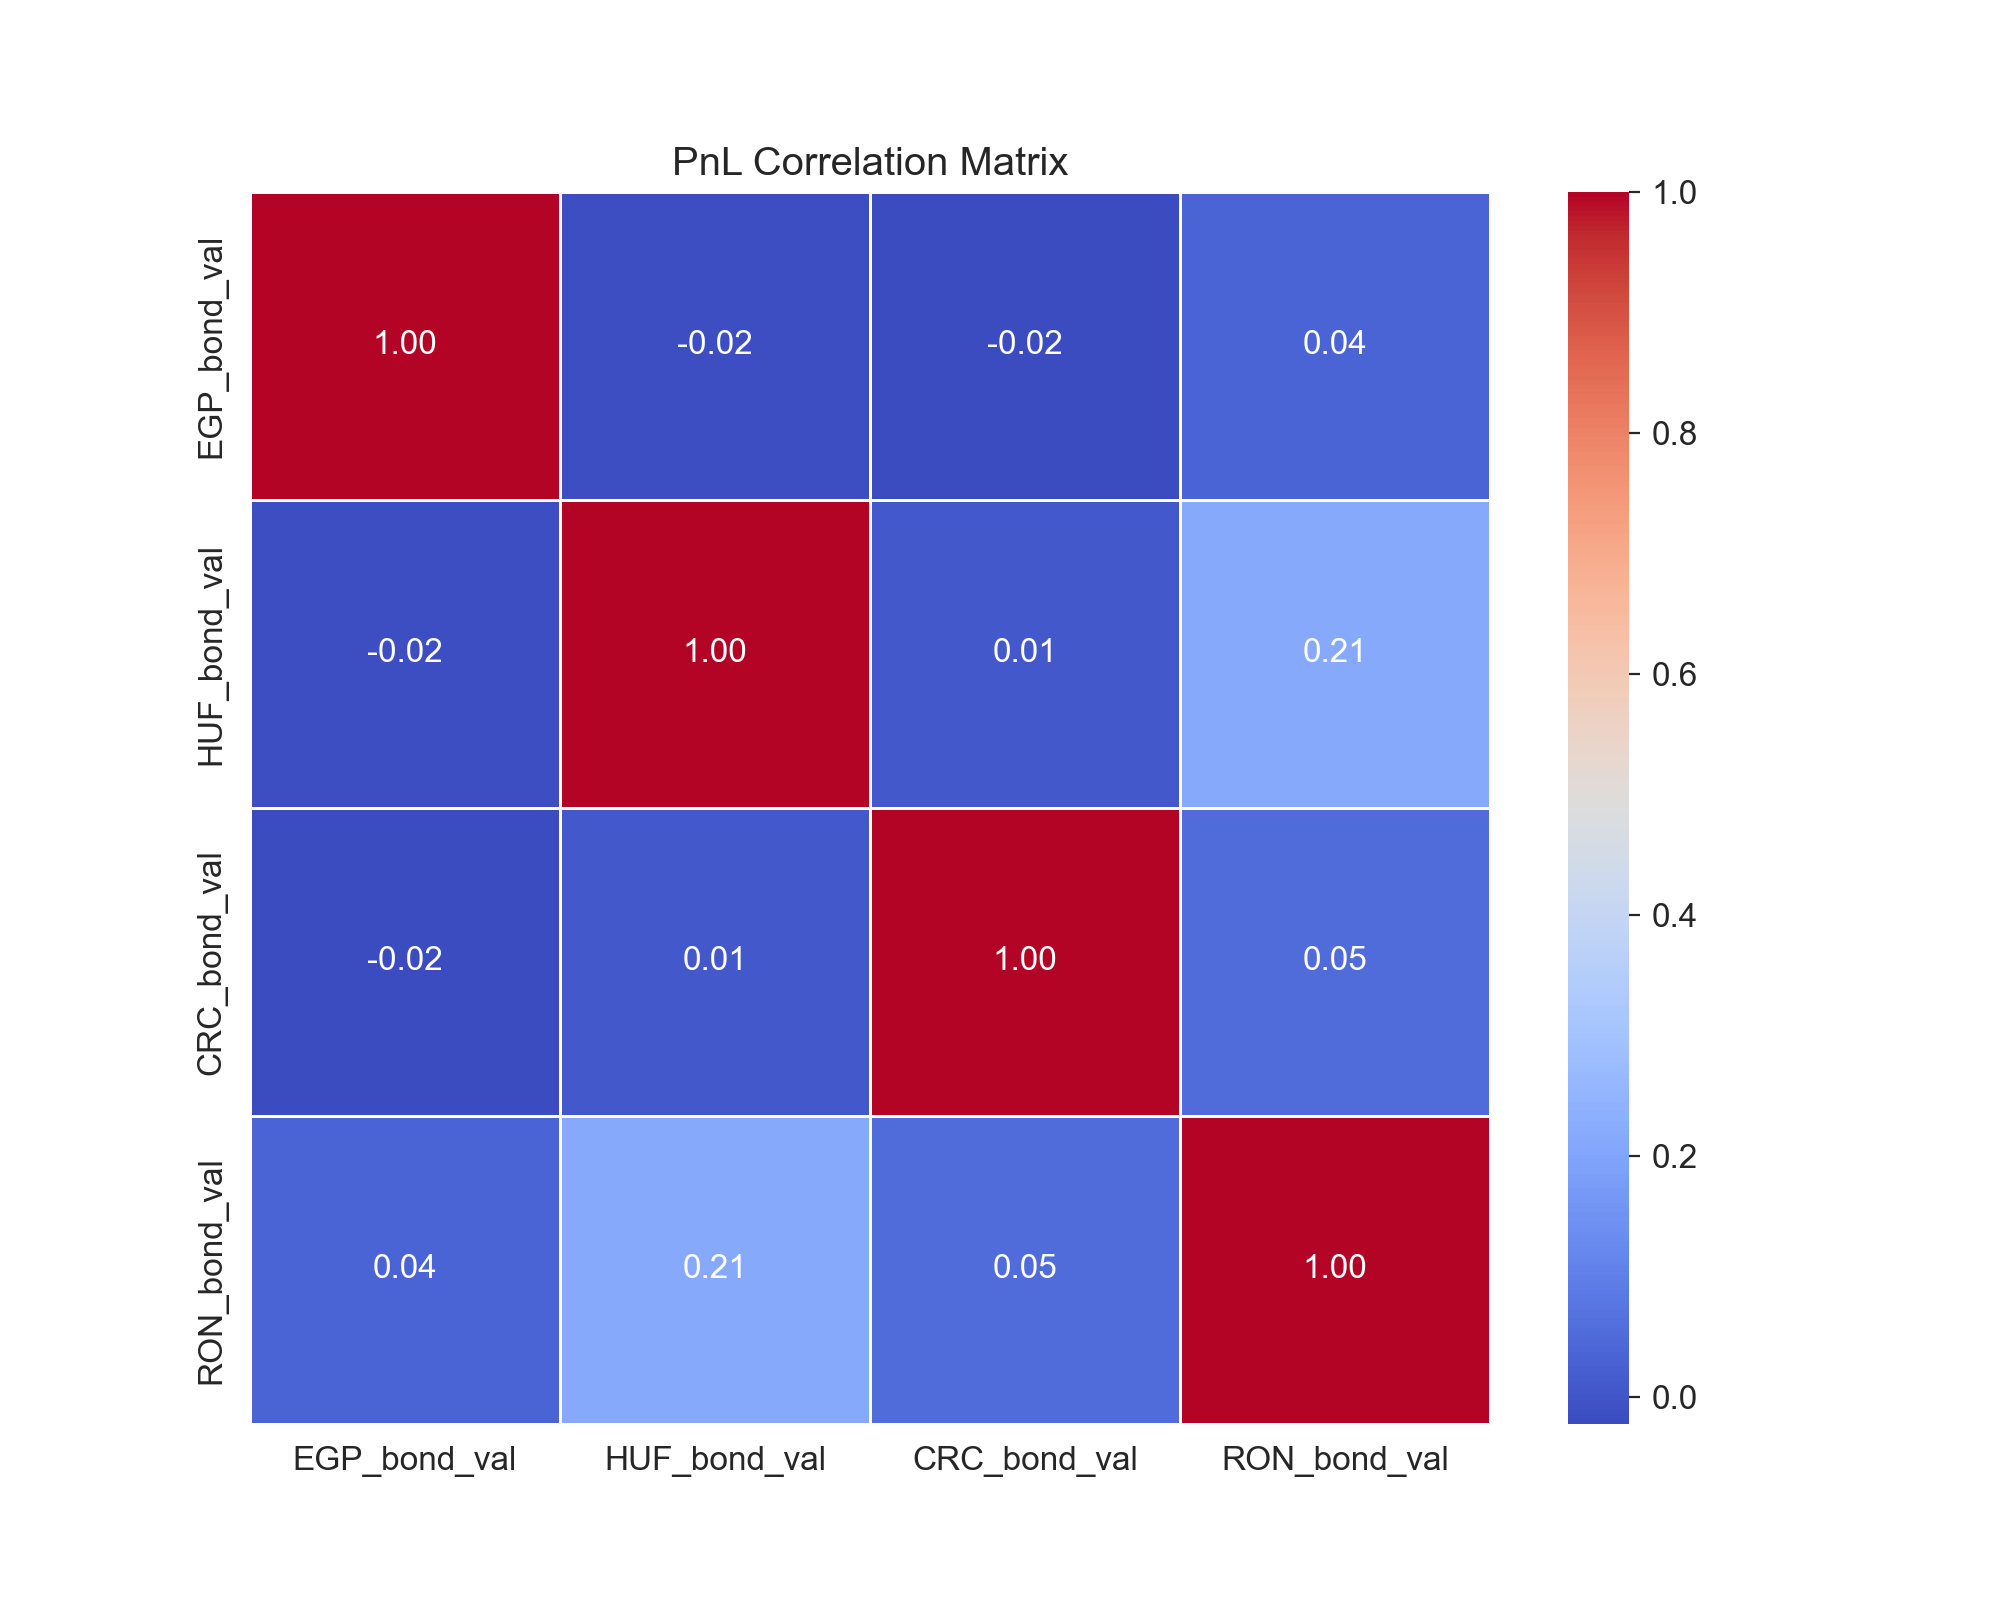

In [615]:
bond_val_df = pd.DataFrame({
    'EGP_bond_val': EGP_pnl_with_cols['bond_val'],
    'HUF_bond_val': HUF_pnl_with_cols['bond_val'],
    'CRC_bond_val': CRC_pnl_with_cols['bond_val'],
    'RON_bond_val': RON_pnl_with_cols['bond_val']
})

bond_val_correlation_matrix = bond_val_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(bond_val_correlation_matrix, annot=True, 
            cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

plt.title('PnL Correlation Matrix')
plt.show()

#### Now this is a much better matrix of correlation values. As expected, a lot of the correlation we saw in the previous matrix was due to the fact that there was a consistent interested and loan change value added to the PnL every week from the GBP calculations. Now that we see the bond values are uncorrelated, we can be confident that a combined carry strategy among all the risky currencies would be sufficiently diversified. As such, we will create one final PnL that includes all four of our risky currencies at an amount of 2.5 million invested into each currency's bonds. To do this, we will change the amount parameter of our calc_pnl function and then add all the new bond values for a given week together. Then, we will subtract 10 million from this amount and add this bond PnL to our GBP PnL.

In [616]:
quarter_EGP_pnl_strat = calc_pnl(EGP_strategy_data, 'EGP', False, 2_500_000)
quarter_HUF_pnl_strat = calc_pnl(HUF_strategy_data, 'HUF', False, 2_500_000)
quarter_CRC_pnl_strat = calc_pnl(CRC_strategy_data, 'CRC', False, 2_500_000)
quarter_RON_pnl_strat= calc_pnl(RON_strategy_data, 'RON', False, 2_500_000)

In [619]:
quarter_EGP_pnl_strat

,EGP_5Y,EGP_rate,EGP_5Y_spot,IUDSOIA,GBP_rate,old_bond_price,new_bond_price,commit_to_trade,new_bond_quant,new_bond_value_USD,old_loan_value_GBP,new_loan_value_USD,interest_paid_USD,weekly_pnl,cumulative_pnl
2012-01-04,0.093155,6.032009,0.092895,0.005269,0.640657,99.037751,99.215330,1,152265.397985,NaN,5125256.0,NaN,NaN,NaN,NaN
2012-01-11,0.093516,6.037501,0.093155,0.005156,0.651322,98.992819,99.171006,1,152473.206117,2.501087e+06,5210576.0,7.869005e+06,1553.977138,130527.707028,130527.707028
2012-01-18,0.086318,6.043214,0.085851,0.005220,0.648996,99.063642,99.228221,1,152508.373862,2.503576e+06,5191968.0,8.028672e+06,1568.061397,-26664.140439,103863.566589
2012-01-25,0.084263,6.041476,0.083095,0.005171,0.641089,98.814176,98.974429,1,152849.424811,2.498467e+06,5128712.0,8.098670e+06,1591.700065,-101794.169676,2069.396914
2012-02-01,0.081968,6.030446,0.080931,0.005010,0.631153,98.899268,99.055286,1,152439.095676,2.510684e+06,5049224.0,8.125941e+06,1589.402794,-116846.474383,-114777.077469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,0.197486,30.898900,0.204007,0.051863,0.791621,98.924522,99.300931,1,780870.594961,2.515218e+06,6332968.0,7.937718e+06,8680.046921,68820.090892,-723712.083044
2024-01-10,0.202035,30.905900,0.208308,0.051872,0.787423,98.718823,99.103119,1,782674.950834,2.503946e+06,6299384.0,8.042651e+06,8794.793009,-47499.081541,-771211.164585
2024-01-17,0.208911,30.904000,0.217051,0.051880,0.793105,99.069441,99.468256,1,779857.027802,2.519134e+06,6344840.0,7.942686e+06,8686.854608,67760.962050,-703450.202535
2024-01-24,0.200456,30.898700,0.203664,0.051875,0.787268,97.843971,98.221880,1,789489.110314,2.479037e+06,6298144.0,8.059314e+06,8815.649602,-89092.531453,-792542.733988


In [622]:
combined_curr_pnl_df = pd.DataFrame()

combined_curr_pnl_df['new_bond_value_USD'] = (
        quarter_EGP_pnl_strat['new_bond_value_USD'] + 
        quarter_HUF_pnl_strat['new_bond_value_USD'] +
        quarter_CRC_pnl_strat['new_bond_value_USD'] +
        quarter_RON_pnl_strat['new_bond_value_USD']
)

combined_curr_pnl_df['new_loan_value_USD'] = quarter_EGP_pnl_strat['new_loan_value_USD']
combined_curr_pnl_df['interest_paid_USD'] = quarter_EGP_pnl_strat['interest_paid_USD']

combined_curr_pnl_df['weekly_pnl'] = (
    (combined_curr_pnl_df['new_bond_value_USD'] - 10_000_000) -
    (combined_curr_pnl_df['new_loan_value_USD'] - 8_000_000) -
    combined_curr_pnl_df['interest_paid_USD']
)

combined_curr_pnl_df['cumulative_pnl'] = combined_curr_pnl_df['weekly_pnl'].cumsum()

combined_curr_pnl_df

,new_bond_value_USD,new_loan_value_USD,interest_paid_USD,weekly_pnl,cumulative_pnl
2012-01-04,NaN,NaN,NaN,NaN,NaN
2012-01-11,9.857624e+06,7.869005e+06,1553.977138,-1.293466e+04,-1.293466e+04
2012-01-18,1.026152e+07,8.028672e+06,1568.061397,2.312759e+05,2.183412e+05
2012-01-25,1.004441e+07,8.098670e+06,1591.700065,-5.585286e+04,1.624884e+05
2012-02-01,1.021976e+07,8.125941e+06,1589.402794,9.222944e+04,2.547178e+05
...,...,...,...,...,...
2024-01-03,7.506591e+06,7.937718e+06,8680.046921,-2.439807e+06,-2.570536e+06
2024-01-10,1.002180e+07,8.042651e+06,8794.793009,-2.964094e+04,-2.600177e+06
2024-01-17,9.986862e+06,7.942686e+06,8686.854608,3.548906e+04,-2.564688e+06
2024-01-24,9.978971e+06,8.059314e+06,8815.649602,-8.915869e+04,-2.653846e+06


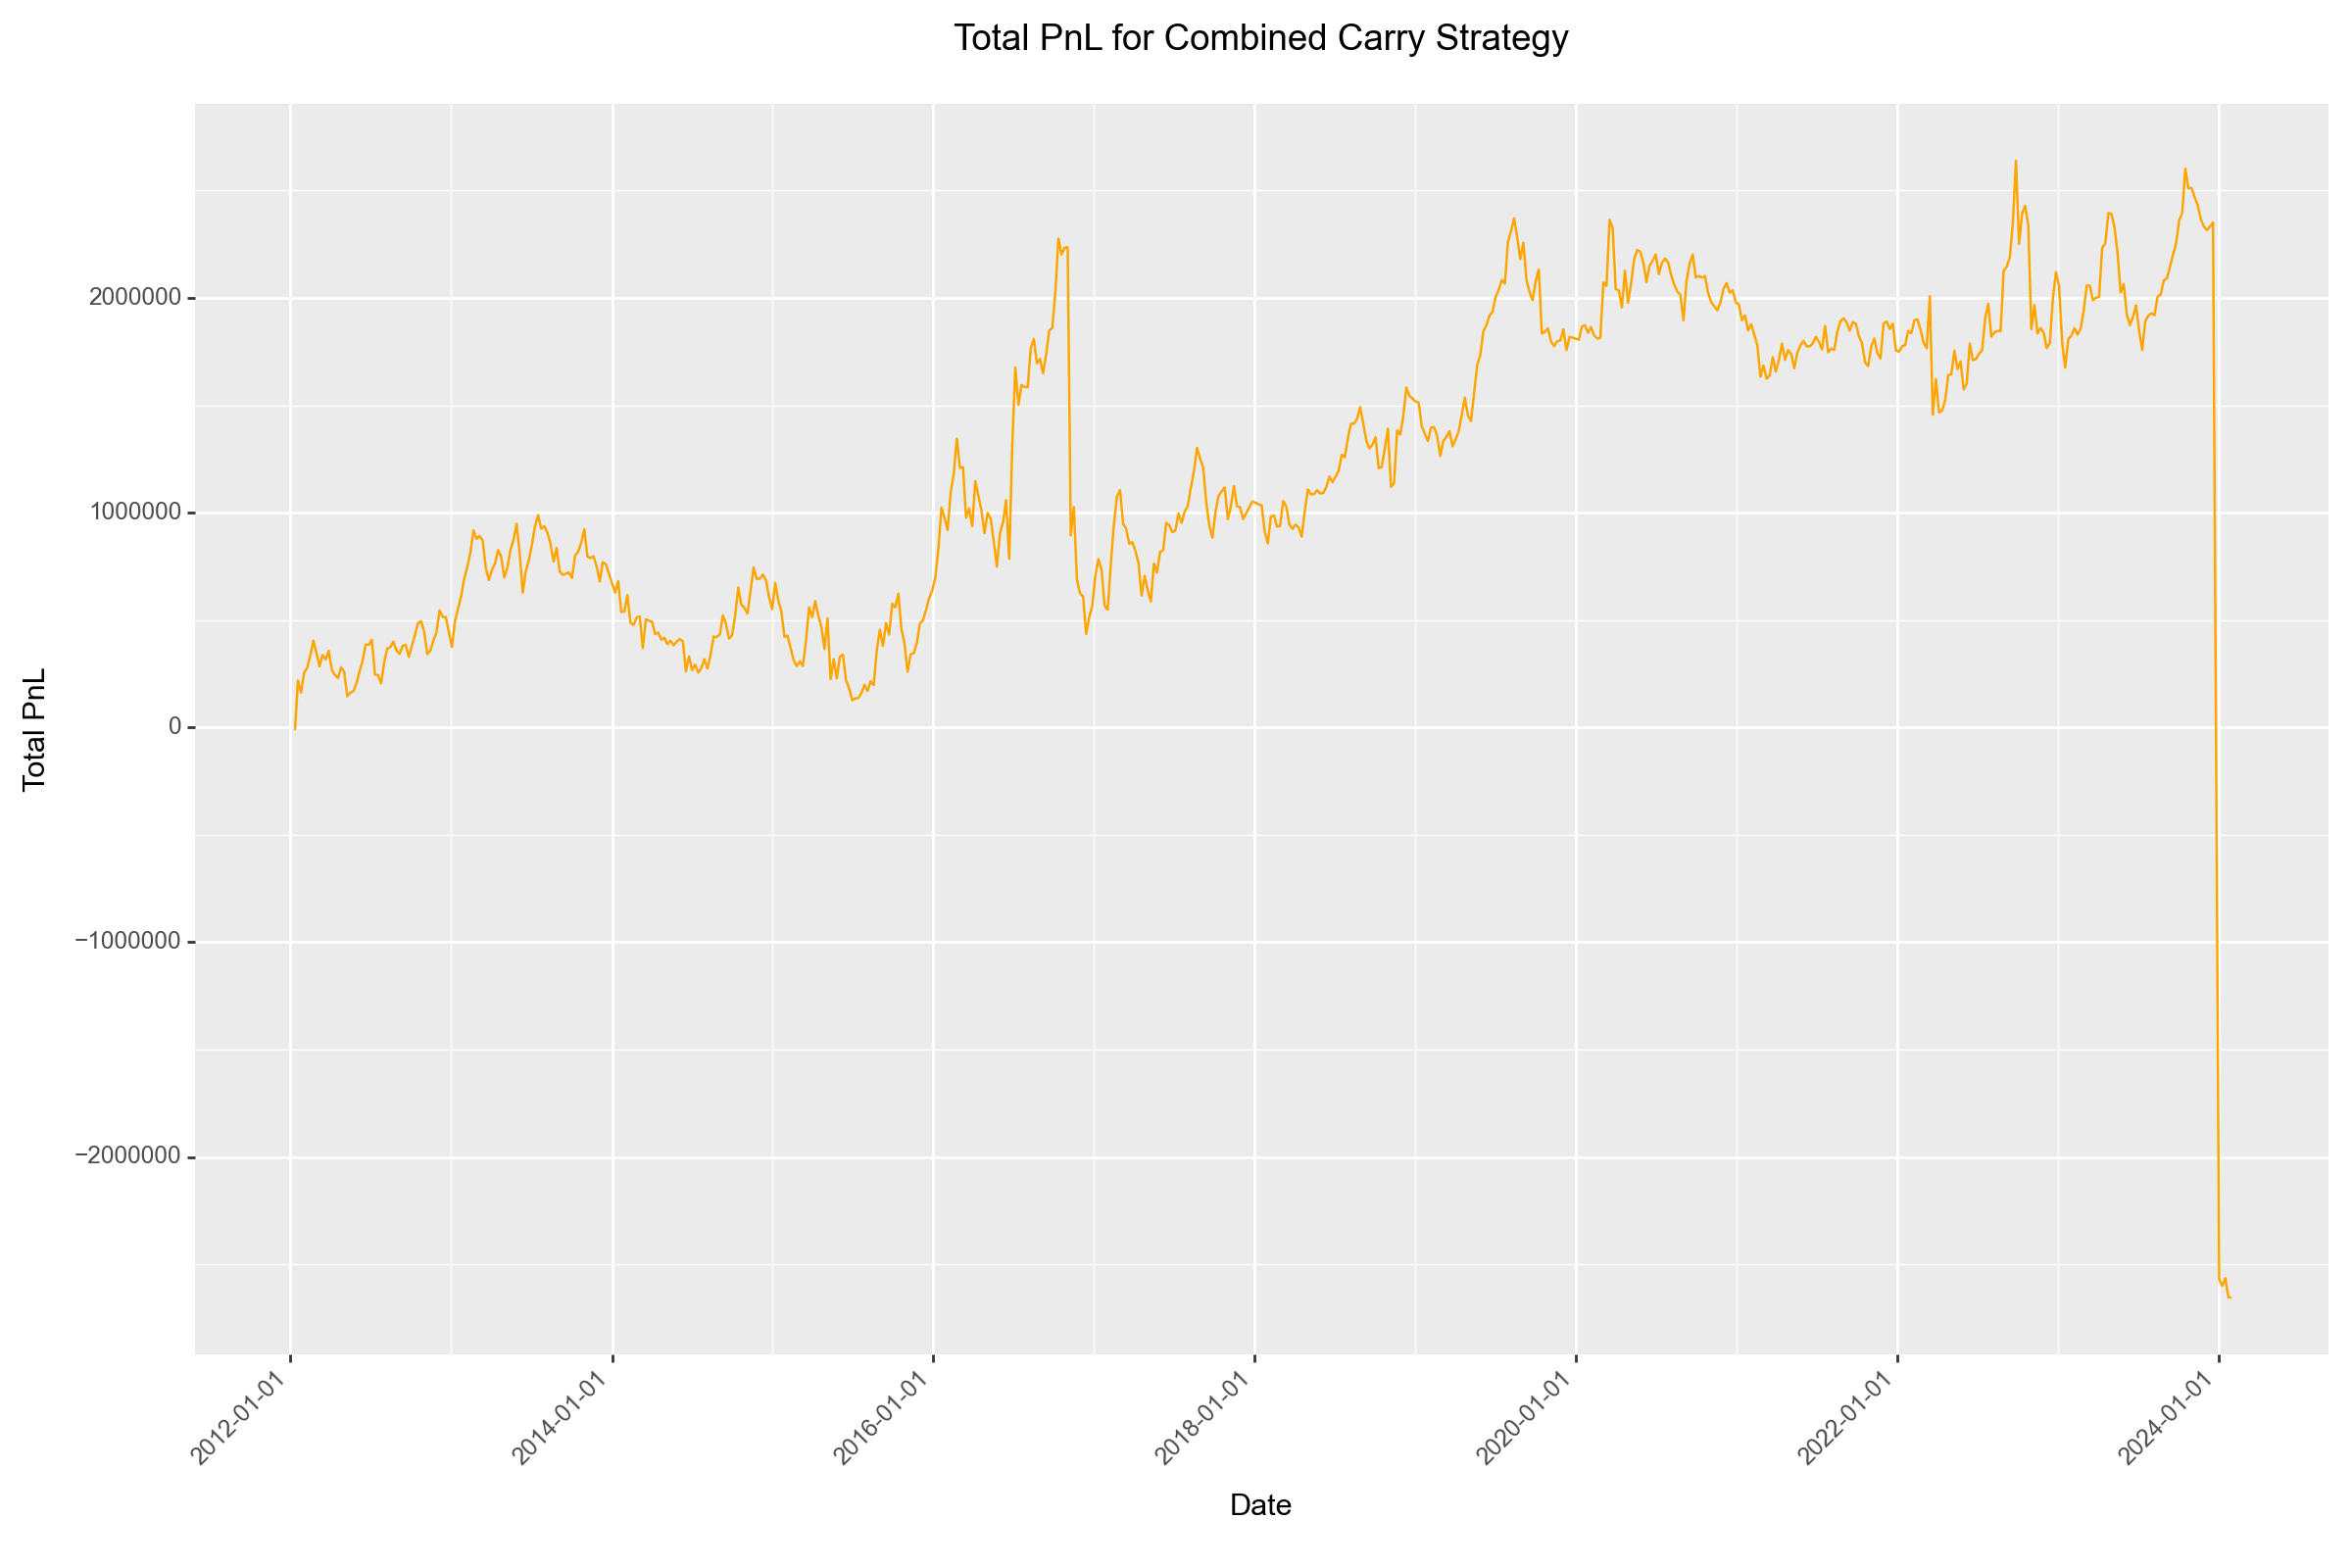

In [623]:
combined_curr_pnl_plot = plot_carry_trade_pnl(combined_curr_pnl_df, 'Combined')
combined_curr_pnl_plot.draw()

#### While we see an absolutely huge drawdown at the end of our period, we are at least very clearly looking at a carry trade strategy. There are obviously some fluctuations throughout the PnL plot, but we see a nice, steady growth in PnL over time and huge decreases in PnL due to outlier events (which in our case are drastic changes to currency FX rates). Even though we have finished in the red, we at least see that our combined carry strategy performs exactly how we would expect it to, generating more reasonable PnL over time and being cushioned by outlier events (except for the last period which is due to an abnormally large increase in HUF. We will analyze the risk metrics of this combined strategy and then conclude by discussing some potential fixes to our strategy.

In [630]:
combined_curr_risk_metrics = calculate_risk_metrics(combined_curr_pnl_df['cumulative_pnl'].to_frame())
combined_curr_risk_metrics

,Value
Metric,
Maximum Drawdown,-5.293670e+06
VaR,2.557324e+05
CVaR,-2.579851e+05
Sharpe Ratio,1.601026e+00


# Conclusion

#### Firstly, we saw that the specific currency carry strategies differed wildly in performance when they were executed on their own. While we could have ended up with a nice PnL chart like CRC, we could have equally found ourselves invested into EGP and losing millions of dollars due to FX rates. Because of these drastic differences in overall PnL, we explored a combined currency strategy and saw results much more aligned with how we expect a typical carry strategy to perform. While there is still incredible downside risk (as we saw from the end of period drawdown), we at least know from our correlation matrix of bond values that we can diversify our FX carry trades using multiple risky currencies at once. Our combined strategy produced a very favourable Sharpe ratio of 1.6, which would warrant further investigation to validate this remarkable return. We also see a maximum drawdown of 5.3 million, which not only completely wiped out our profits but also left us with another 2 million in losses. 

#### If we were to consider this strategy for future implementations, we would need to address this massive drawdown issue. We notice that this only occurred because we had such a large amount invested into a currency that ended up spiking in FX rate. This is a tail event that is generally unavoidable and unpredictable, which means we have to be clever about how we address the issue. Our first fix would be to invest into more risky currencies. While this leaves us exposed to more of these tail events, we would have sufficiently spread our capital so that such events would be less impactful on our PnL drawdowns. Another potential fix would be to invest into currencies whose FX rate we expect to be uncorrelated. We would suffer massive losses if multiple currencies saw FX drops at the same time, so having uncorrelated FX rates would lessen the chance of two tail events happening simultaneously across two risky currencies. Finally, we may wish to implement a dynamic strategy that allocates different capital amounts to different currencies based on overall market conditions and observations we make about FX returns. This would require an in-depth analysis of the FX markets and understanding pseudo-predictable patterns that we could leverage through statistical analysis (we say psuedo since the market is inherently unpredictable). All of these implementations would benefit our strategy and help to reduce the drawdown issue we see, which is the main reason we are observing such sharp declines in our PnL.